# IMPORTS

## LIBRARIES

In [1]:
import re
import math
import random
import pickle
import datetime
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
from matplotlib                import gridspec
from IPython.display           import Image
from scipy                     import stats 
from sklearn.model_selection   import train_test_split
from sklearn.preprocessing     import MinMaxScaler
from sklearn.impute            import SimpleImputer
from boruta                    import BorutaPy
from sklearn.ensemble          import RandomForestRegressor
from xgboost                   import XGBRegressor
from sklearn.metrics           import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model      import LinearRegression
from sklearn.linear_model      import Lasso
from sklearn.dummy             import DummyRegressor
from sklearn.neighbors         import KNeighborsRegressor
from lightgbm                  import LGBMRegressor

## FUNCTIONS

In [2]:
def initial_settings():
    '''
    Set initial settings for dataframe and plot diplays
    '''

    # set cientific notation for pandas
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    # set default plt figure size
    plt.rcParams['figure.figsize'] = [24, 12]
    # set default plt font size
    plt.rcParams['font.size'] = 24

    # set cell size to be expanded
    display( HTML( '<style>.container { width:100% !important; }</style>') )

    # set figures to seaborn style
    sns.set()

    
    return None

def check_dataframe( dataframe, sample_size = 5 ):
    '''
    Print number of NAs, percentage of NA to the given column,
    number of unique values, data types, dataframe shape and 
    return a random sample of dataframe'''
    
    # create dictionary with descriptive information
    dict_data = {'Num NAs': dataframe.isna().sum(),
                 'Percent NAs': dataframe.isna().mean(),
                 'Num unique': dataframe.nunique(),
                 'Data Type': dataframe.dtypes }
  
    # print descriptive data
    print( pd.DataFrame( dict_data ), '\n' )
    # print dataframe shape
    print( f'Dataframe shape is {dataframe.shape}', '\n' )  
    
    
    return dataframe.sample( sample_size )


def na_inputter( dataframe, column, inputter, transform = False, save_inputter = False, flag_column = False ):
    """
    Apply inputer to the given column on the datafame. Also check if user wants to 
    transform the column after fitting inputer, if the user wants to save the fitted inputer,
    and if the user wants to create a flag column for missing values indications of the given column.

    Args:
        dataframe: the dataframe with the given column to apply inputer.
        column: the given column name to apply the inputer.
        inputer: the inputer object.
        transform: bool to indicate if user want to transform the given column.
        save_inputter: bool to indicate if user want to save inputer as pickle file.
        flag_column: bool to indicate if user want to create a flag column for missing values.

    Return:
        dataframe: original dataframe with requested operations, if any."""

    
    
    # make inputter learn from given column
    fitted_inputter = inputter.fit( dataframe[ column ].values.reshape(-1, 1) )
     
    # check if want to save inputer for future transformations on the given column
    if save_inputter:
        # save inputter as pickle file
        with open(f'../src/features/{column}_inputter.pkl', 'wb') as file: 
            pickle.dump( fitted_inputter, file)       

    # check if want to create flag column to NA values        
    if flag_column:
        dataframe[ column + '_NA' ] = np.where( dataframe[ column ].isna(), 1, 0 ) 
    
    
    # check if want to transform the column (or just fit)
    if transform:
        # transform given column with fitted inputter
        dataframe[ column ] = fitted_inputter.transform( dataframe[ column ].values.reshape(-1, 1) )

    
    return dataframe


def numerical_statistics( dataframe ):
    '''
    Calculate statistics for all columns in the dataframe
    
    Args: 
        dataframe: dataframe with only numerical features
    
    Return: 
        stats_df: dataframe with statistics for every feature. 
                  Rows are original dataframe features.
                  Columns are statistics applied.'''
    
    # central tendency statistics
    mean_stats = pd.DataFrame( dataframe.apply( np.mean ) ).T
    median_stats  = pd.DataFrame( dataframe.apply( np.median ) ).T
    
    # deviation statistics
    std_stats = pd.DataFrame( dataframe.apply( np.std ) ).T
    min_stats = pd.DataFrame( dataframe.apply( min ) ).T
    max_stats = pd.DataFrame( dataframe.apply( max ) ).T
    range_stats = pd.DataFrame( dataframe.apply( lambda x: x.max() - x.min() ) ).T
    skew_stats = pd.DataFrame( dataframe.apply( lambda x: x.skew() ) ).T
    kurtosis_stats = pd.DataFrame( dataframe.apply( lambda x: x.kurtosis() ) ).T
    
    # concatenate statistics    
    stats_df = pd.concat( [  mean_stats,
                             median_stats,
                             std_stats,
                             min_stats,
                             max_stats,
                             range_stats,
                             skew_stats,
                             kurtosis_stats   ] ).T.reset_index()
    
    # rename columns
    stats_df.columns = ['attribute', 
                       'mean',
                       'median',
                       'std',
                       'min',
                       'max',
                       'range',
                       'skew',
                       'kurtosis'    ]
    
    
    return stats_df      


def numerical_plot( dataframe, column, figsize = (10, 7) ):
    '''
    Plot histogram on the upper axs and 
    boxplot on the lower axs.
    
    Args:
        dataframe: datataframe with numerical features
        column: numerical feature to be plotted
        figsize: (width, height) in inches [figsize from plt].
    
    Return:
        None
    '''
       
    # create a figure object
    fig = plt.figure( figsize = figsize, constrained_layout = True );

    # create a grid for plotting
    specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig);

    # check sales distribution
    hist_axs = fig.add_subplot( specs[ 0, 0 ] )
    box_axs = fig.add_subplot( specs[ 1, 0 ] )

    # set title
    hist_axs.set_title( column.upper() )
    # plot histogram
    sns.histplot( x = column, data = dataframe, ax = hist_axs, kde = True )
    # plot boxplot
    sns.boxplot(  x = column, data = dataframe, ax = box_axs )
    
    
    return None


def reverse_inputation( dataframe, column, flag_column,
                        response_variable = 'response_variable',
                        reverse_inputter = np.nan,
                        remove_rows = False, response = False,
                        reverse_input = True,
                        only_col_return = False):  
    """
        Reverse missing value inputation on the dataframe given a flag column.
    It can: (1) remove flagged rows, (2) replace flagged values on the given column
    with some given value (reverse_inputter), (3) include the response variable on
    returned dataframe, (4) return only the given column with inputation reverted.
    
    
    Args:
        dataframe: the dataframe with the given columns.
        column: the given column name to reverse inputing.
        flag_column: the flag_column for the given column.
        response_variable: response variable of the dataframe.
        reverse_inputter: value to replace the original missing values.
        remove_rows: bool to remove (or not) flagged rows.
        response: bool to check if user wants to include response variable 
            on the returned dataframe
        reverse_input: bool to replace the original missing value 
            with reverse_inputter value.
        only_col_return: bool to check if user wants only the given column
            on the returned dataframe
        
    Return:
        dataframe: a copy o the original dataframe with the requested operation."""
    
    # create a dict with control params
    bool_check = {'remove_rows': remove_rows, 
                 'response': response,
                 'reverse_input': reverse_input,
                 'only_col_return': only_col_return
                  }
    
    # check control params
    for bool_name, bool_value in bool_check.items():
        assert (type(bool_value) == bool), f'{bool_name} is not boolean !!!'

    # check if remove_rows and reverse_input has opposite values
    assert (remove_rows != reverse_input), '''remove_rows and reverse_input must be opposite booleans. 
            Choose only one operation.'''
    
    # check if flag_column is different than column
    assert ( column != flag_column ), '''column' and 'flag_column' must be different, 
        you set them equal.'''
          
    
    # check if user wants response variable on dataframe    
    if response:
        # create auxiliary dataframe with column, flag_column and
        # response_variable as columns 
        df_aux = dataframe[ [column, flag_column, response_variable] ].copy()
    else:
        # create auxiliary dataframe with column, flag_column as columns 
        df_aux = dataframe[ [column, flag_column] ].copy()
        
    # create a series with flag information
    flags = df_aux[ flag_column ].astype( 'bool')
    
    # if the user wants to remove flagged rows
    if remove_rows:
        # remove rows where a value was inputed on the given column
        df_aux = df_aux.loc[ ~flags, : ]
    
    # if user wants to input a value to the flagged rows on the given column
    if reverse_input:
        # input a value to the flagged rows
        df_aux.loc[ flags, column ] = reverse_inputter
        
    # return only given column with inputation reverted
    if only_col_return:
        df_aux = df_aux[ column ]
 

    return df_aux


def cramer_v_corrected_stat( series_one, series_two ):
    '''
    Calculate crame v statistics for two categorical series 
    
    Args:
        series_one: first categorical dataframe column
        series_two: second categorical dataframe column
    
    Return:
        corr_cramer_v: corrected Cramer-V statistic
    '''
     
    # check in case scipy.stats wasn't imported
    from scipy import stats 

    # create confusion matrix
    cm = pd.crosstab( series_one, series_two )
    # calculate the sum along all dimensions
    n = cm.sum().sum()
    # calculate number of row and columns of confusion matrix
    r, k = cm.shape

    # calculate chi_squared statistics
    chi2 = stats.chi2_contingency( cm )[0]
    
    # calculate chi_squared correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    # calculate k correction
    kcorr = k - (k-1)**2/(n-1)
    # calculate r correction
    rcorr = r - (r-1)**2/(n-1)

    # calculate corrected cramer-v
    corr_cramer_v = np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
   
    
    return corr_cramer_v


def create_cramer_v_dataframe( categ_features_analysis_dataframe ):
    '''
    Create a correlation matrix for features on categorical dataframe
    
    Args:
        categ_features_analysis_dataframe: dataframe with only categorical features
    
    Return:
        categ_corr_matrix: dataframe with cramer-v for every row-column pair 
                           in the input dataframe'''
    
    # create final dataframe skeleton
    df_cramer_v = pd.DataFrame( columns = categ_features_analysis_dataframe.columns, 
                                index = categ_features_analysis_dataframe.columns )

    # fill final dataframe with cramer-v statistics for every row-column pair
    for row in df_cramer_v:
        for column in df_cramer_v:   
            df_cramer_v.loc[row, column] = float( cramer_v_corrected_stat( categ_features_analysis_dataframe[ row ],
                                                                           categ_features_analysis_dataframe[ column] ) )

    # ensure cramer-v is float
    categ_corr_matrix = df_cramer_v.astype( 'float' )
        
        
    return categ_corr_matrix


def engineer_features( X_dataframe, X_columns ):
    """
    Apply the same chosen feature transformations that were fit on
    the X_train.

    Args:
        X_dataframe: X_train or X_validation or X_test dataframe to apply
            feature engineering according to choosen feature transformations
            that were fit on the X_train.
        X_columns: columns of X_train or X_validation or X_test dataframe 
            to apply feature engineering according to choosen feature 
            transformations that were fit on the X_train.

    Return:
        X_dataframe: return the X_dataframe transformed.
    """ 
    
    # iterate over columns
    for column in X_columns:
        
        ####################
        # check if MISSING VALUE INPUTATION is required
        if column in ['competition_open_since_month',
                      'competition_open_since_year',
                      'promo2_since_week',
                      'promo2_since_year',
                      'promo_interval'
                     ]:
            # load inputter as pickle file
            with open(f'../src/features/{column}_inputter.pkl', 'rb') as file: 
                inputter = pickle.load(file)       

            # transform given column with inputter
            X_dataframe[ column ] = inputter.transform( X_dataframe[ column ].values.reshape(-1, 1) )

            
        ####################    
        # no NORMALIZATION yet
        
        
        ####################
        # check if RESCALING is required
        if column in ['store', 
                      'competition_open_since_month',
                      'promo2_since_week', 
                      'promo2_since_year', 
                      'year'
                     ]:

            # load  scaler 
            with open(f'../src/features/{column}_scaler.pkl', 'rb') as file: 
                scaler = pickle.load( file )
            # transform col_outlier
            X_dataframe[ column ] = scaler.transform( X_dataframe[ column ].values.reshape(-1,1) )
        
        
        ####################
        # check if DISCRETIZATION is required
        if column in ['competition_open_since_year',
                      'competition_distance'
                     ]:
        
            # dictionary with feateres and their bins
            dict_bins = {'competition_open_since_year': [1989, 1990, 1995, 2000, 2005, 2008, 2010, 2012, 2014, 2016],
                         'competition_distance': [0, 50, 100, 500, 1000, 5000, 15000, 100000]
                        }

            # discretize column
            X_dataframe[ column ] = pd.cut( X_dataframe[ column ], bins = dict_bins[ column ] )
            # convert categoric dtype to integer
            X_dataframe[ column ] = pd.Categorical( X_dataframe[ column ] ).codes
            # make category labels range from 0 to 2
            X_dataframe[ column ] = X_dataframe[ column ] / ( ( len( dict_bins[ column ] ) - 2 ) / 2 )

            
                
         ####################       
        # check if ENCODING is required
        if column in ['store_type', 
                      'assortment', 
                      'promo_interval'
                     ]:

            # auxiliary list to encode
            aux_dict = {'store_type': {'a': 0, 'd': 1, 'c': 2, 'b': 3},
                        'assortment': {'basic': 0, 'extended': 1, 'extra': 2},
                        'promo_interval': {'Mar,Jun,Sept,Dec': 0,
                                            'Feb,May,Aug,Nov': 1,
                                            'Jan,Apr,Jul,Oct': 2 }
                       }
                       
            # map feature
            X_dataframe[ column ] = X_dataframe[ column ].map( aux_dict[ column ] )


        ####################
        # check if NATURE TRANSFORMATION is required
        if column in ['season',
                      'day_of_month',
                      'day_of_year',
                      'month',
                      'week_number',
                      'day_of_week'
                     ]:

            # check season especific engineering
            if column == 'season':
                # create season dictionary for mapping
                season_map = {
                    'winter': 0, 
                    'spring': 1, 
                    'autumn': 2, 
                    'summer': 3
                }

                # map season feature
                X_dataframe['season'] = X_dataframe['season'].map( season_map )

            # dict with feature and its cycle
            cyclic_dict = {
                'season': 4,
                'day_of_month': 30,
                'day_of_year': 365,
                'month': 12,
                'week_number': 52,
                'day_of_week': 7
            }

            # apply sin and cos transformation on features    
            X_dataframe[ f'{column}_sin' ] = X_dataframe[ column ].apply( lambda x: np.sin( x * ( 2. * np.pi/ cyclic_dict[ column ] ) ) )
            X_dataframe[ f'{column}_cos' ] = X_dataframe[ column ].apply( lambda x: np.cos( x * ( 2. * np.pi/ cyclic_dict[ column ] ) ) )
            # remove cyclic column from dataframe
            X_dataframe.drop( columns = [ column ], axis = 'columns', inplace = True )
    
    
    return X_dataframe


def time_series_cross_validation( X_train_model, y_train_model, kfold, model_name, model, verbose = False ):
    """
    Calculate cross-validation metrics (MAE, MAPE, RMSE and MPE) for time-series.

    Args:
        X_train_model: X dataframe with just values ( X_train.values )
        y_train_model: y dataframe with just values ( y_train.values )
        kfold: number of folds for cross-validation
        model_name: model name to show on final report
        model: instanciated machine learning model
        verbose: print information for each cross-validation step
    
    Return:
        cv_report: dataframe with error report metrics
        
    NOTE: 
        This function takes into account the following packages:
            from sklearn.metrics
                import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error   
    """   
    
    # create auxiliary lists
    mae_list = []
    mape_list = []
    rmse_list = []
    mpe_list = []
    
    # date series from X_train
    date_series = X_train['date']
        
    # create descending list from "kfold + 1" till "1"
    for k in reversed( range( 1, kfold+1 ) ):
        
        # check is verbosity was requested
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        
        # start date for validation 
        validation_start_date = X_train['date'].max() - datetime.timedelta( days = k * 6 * 7 )
        # end date for validation 
        validation_end_date = X_train['date'].max() - datetime.timedelta( days = (k-1) * 6 * 7 )

        # filter cross-validation training dataset
        cv_X_train = X_train_model[ date_series < validation_start_date ]
        cv_y_train = y_train_model[ date_series < validation_start_date ]
        
        # filter cross-validation validation dataset
        cv_X_validation = X_train_model[ (date_series >= validation_start_date) & (date_series < validation_end_date) ]
        cv_y_validation = y_train_model[ (date_series >= validation_start_date) & (date_series < validation_end_date) ]

        
        # fit model to training cross-validation data
        m = model.fit( cv_X_train, cv_y_train )

        # make predictions with model
        yhat = m.predict( cv_X_validation )

        # calculate performance
        # np.where is used to avoid 'division by zero' error
        # in case of sales = zero.
        m_result = ml_error( model_name, 
                             np.where( np.expm1( cv_y_validation ) == 0, 1, np.expm1( cv_y_validation ) ), 
                             np.where( np.expm1( yhat ) == 0           , 1, np.expm1( yhat )            )
                           )
        
        # append performance of each kfold iteration on lists
        mae_list.append(  m_result['MAE']  )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        mpe_list.append(  m_result['MPE']  )
        
        
    # create final dataframe with performance indicators    
    cv_report = pd.DataFrame( {
                              'Model Name': model_name,
                              'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                              'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                              'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ), 
                              'MPE CV': np.round( np.mean( mpe_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mpe_list ), 2 ).astype( str )
                              }, index = [0]
                            )

        
    return cv_report

   
   
def mean_percentage_error( y, yhat ):
    """
    Calculate 'mean percentage error' (MPE): (y - yhat) / y 
    """

    return np.mean( ( y - yhat ) / y )

    
def ml_error( model_name, y, yhat ):
    """
    Calculate:
        MAE (Mean Absolute Error), 
        MAPE (Men Absolute Percentage Error),
        RMSE (Root Mean Squared Error),
        MPE (Mean Percentage Error),       
    """
    
    # calculate MAE
    mae = mean_absolute_error( y, yhat )
    # calculate MAPE
    mape = mean_absolute_percentage_error( y, yhat )
    # calculate RMSE
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    # calculate MPE
    mpe = mean_percentage_error( y, yhat )    
    
    # create dataframe with error report
    error_report = pd.DataFrame( { 'Model Name': model_name, 
                                   'MAE': mae, 
                                   'MAPE': mape,
                                   'RMSE': rmse,
                                   'MPE': mpe
                                 }, index=[0] )
        
    return error_report




# DATA EXTRACTION

## Files Description

**train.csv** - historical data including Sales

**test.csv** - historical data excluding Sales

**store.csv** - supplemental information about the stores

## Data Fields Description 

**Id** - an Id that represents a (Store, Date) duple within the test set

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

**StoreType** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance** - distance in meters to the nearest competitor store

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Data Loading

In [3]:
# load data from train.csv
df_train_extraction = pd.read_csv( '../data/train.csv', low_memory = False )
df_train_extraction.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# check dataframe shape
df_train_extraction.shape

(1017209, 9)

In [5]:
# load data from store.csv
df_store_supl_extraction = pd.read_csv( '../data/store.csv', low_memory = False )
df_store_supl_extraction.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# check dataframe shape
df_store_supl_extraction.shape

(1115, 10)

## Merge Data

In [7]:
# merge dataframes on Store column
df_extraction = pd.merge( df_train_extraction, 
                          df_store_supl_extraction,
                          how = 'left', 
                          on = 'Store'
                        )
df_extraction.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df_extraction.shape

(1017209, 18)

# DATA DESCRIPTION

## Restore Point

In [9]:
# create a restore point for the previous section dataframe
df_description = df_extraction.copy()
check_dataframe( df_description )

                           Num NAs  Percent NAs  Num unique Data Type
Store                            0     0.000000        1115     int64
DayOfWeek                        0     0.000000           7     int64
Date                             0     0.000000         942    object
Sales                            0     0.000000       21734     int64
Customers                        0     0.000000        4086     int64
Open                             0     0.000000           2     int64
Promo                            0     0.000000           2     int64
StateHoliday                     0     0.000000           4    object
SchoolHoliday                    0     0.000000           2     int64
StoreType                        0     0.000000           4    object
Assortment                       0     0.000000           3    object
CompetitionDistance           2642     0.002597         654   float64
CompetitionOpenSinceMonth   323348     0.317878          12   float64
CompetitionOpenSince

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
181692,1063,4,2015-02-19,5048,581,1,1,0,0,a,c,6250.0,NaN,NaN,0,NaN,NaN,NaN
597940,1086,7,2014-01-12,0,0,0,0,0,0,a,a,180.0,11.0,2013.0,1,18.0,2011.0,"Feb,May,Aug,Nov"
251434,112,1,2014-12-15,9147,988,1,1,0,0,a,a,1630.0,9.0,2009.0,0,NaN,NaN,NaN
179137,738,6,2015-02-21,9317,737,1,0,0,0,d,c,5980.0,10.0,2005.0,0,NaN,NaN,NaN
699388,1069,7,2013-10-13,0,0,0,0,0,0,a,c,18050.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## Column Names

In [10]:
# check column names
[ print( column ) for column in df_description.columns ];

Store
DayOfWeek
Date
Sales
Customers
Open
Promo
StateHoliday
SchoolHoliday
StoreType
Assortment
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
PromoInterval


In [11]:
# change from Pascal case to snake case
snake_case = [ '_'.join( re.findall('([A-Z][a-z0-9]+)', column) ).lower()
                for column in df_description.columns ]
    
df_description.columns = snake_case

## Data Dimensions

In [12]:
# check number of rows and columns
print( f'\
Dataframe has {df_description.shape[0]:,} \
rows and {df_description.shape[1]} columns' )

Dataframe has 1,017,209 rows and 18 columns


## Data Types

In [13]:
# check if data types on dataframe makes sense according to database information
df_description.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
# convert data column to date format, instead of string
df_description['date'] = pd.to_datetime( df_description['date'], format = '%Y-%m-%d' )

## Check NAs

In [15]:
# check number of NA values on each column
df_description.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [16]:
# check percentage of NA values on each column
df_description.isna().mean()

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## Fill Out NAs

In [17]:
# numeric features -> median
median_inputter = SimpleImputer( missing_values = np.nan, strategy = 'median' )

# categorical features -> most frequent
most_frequent_inputter = SimpleImputer( missing_values = np.nan, strategy = 'most_frequent' )


# fill competition_distance column
na_inputter( df_description, 'competition_distance', median_inputter, 
            transform = True, save_inputter = True )

# fill competition_open_since_month column
na_inputter( df_description, 'competition_open_since_month', 
            most_frequent_inputter, transform = True, flag_column = True)

# fill competition_open_since_year column
na_inputter( df_description, 'competition_open_since_year', 
            most_frequent_inputter,  transform = True, flag_column = True)

# fill promo2_since_week column
na_inputter( df_description, 'promo2_since_week', 
            most_frequent_inputter,  transform = True, flag_column = True)

# fill promo2_since_year column
na_inputter( df_description, 'promo2_since_year', 
            most_frequent_inputter,  transform = True, flag_column = True)

# fill promo_interval column
na_inputter( df_description, 'promo_interval', 
            most_frequent_inputter,  transform = True, flag_column = True);

## Descriptive Statistics

In [18]:
# check dataframe
check_dataframe( df_description )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0          0.0        1115   
day_of_week                            0          0.0           7   
date                                   0          0.0         942   
sales                                  0          0.0       21734   
customers                              0          0.0        4086   
open                                   0          0.0           2   
promo                                  0          0.0           2   
state_holiday                          0          0.0           4   
school_holiday                         0          0.0           2   
store_type                             0          0.0           4   
assortment                             0          0.0           3   
competition_distance                   0          0.0         654   
competition_open_since_month           0          0.0          12   
competition_open_since_year       

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,competition_open_since_month_NA,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA
586275,571,3,2014-01-22,7301,533,1,1,0,0,d,...,1995.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",0,0,0,0,0
715534,490,6,2013-09-28,9615,1221,1,0,0,0,a,...,2013.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",0,0,0,0,0
695006,32,3,2013-10-16,3192,478,1,0,0,0,a,...,2013.0,1,45.0,2009.0,"Feb,May,Aug,Nov",1,1,0,0,0
707456,217,6,2013-10-05,4278,630,1,0,0,0,c,...,2013.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1,1,1,1
299038,15,6,2014-10-25,4421,567,1,0,0,0,d,...,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0,0,0,0,0


In [19]:
# split columns into date, numerical and categorical dataframes
df_date = df_description['date']

df_num = df_description[['store',
                         'sales',
                         'customers',
                         'competition_distance',
                         'competition_open_since_year'
                        ]]

df_cat = df_description[['day_of_week',
                         'open',
                         'promo',
                         'state_holiday',
                         'school_holiday',
                         'store_type',
                         'assortment',
                         'promo2',
                         'promo_interval',
                         'competition_open_since_month',
                         'promo2_since_week',                         
                         'promo2_since_year'          
]]

### Date data

In [20]:
# check date date
df_date.sample( 10 )

760562   2013-08-19
476853   2014-04-30
748593   2013-08-29
848133   2013-06-01
933165   2013-03-17
631017   2013-12-13
646033   2013-11-29
978650   2013-02-04
221591   2015-01-14
96561    2015-05-06
Name: date, dtype: datetime64[ns]

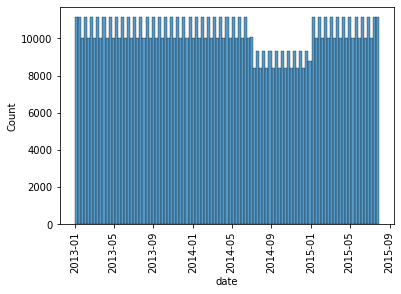

In [21]:
# plot date date
sns.histplot( x = df_date )
plt.xticks( rotation = 90 );

### Numerical data

In [22]:
# check numerical dataframe
print( f'Numerical dataframe has a {df_num.shape} shape' )
df_num.head()

Numerical dataframe has a (1017209, 5) shape


,store,sales,customers,competition_distance,competition_open_since_year
0,1,5263,555,1270.0,2008.0
1,2,6064,625,570.0,2007.0
2,3,8314,821,14130.0,2006.0
3,4,13995,1498,620.0,2009.0
4,5,4822,559,29910.0,2015.0


In [23]:
# calculate statistics for numerical data
numerical_statistics( df_num )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
2,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
3,competition_distance,5422.033790,2330.0,7706.909256,20.0,75860.0,75840.0,2.933466,13.040563
4,competition_open_since_year,2010.060208,2012.0,5.340754,1900.0,2015.0,115.0,-7.884662,139.910688


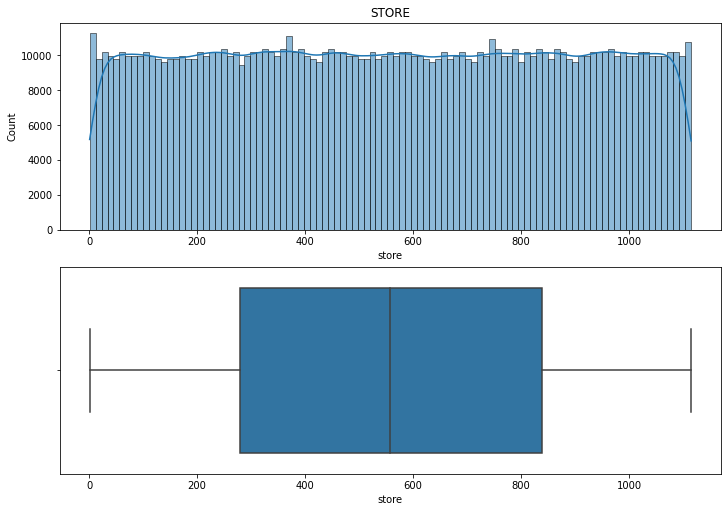

In [24]:
# check sales distribution
numerical_plot( df_num, 'store')

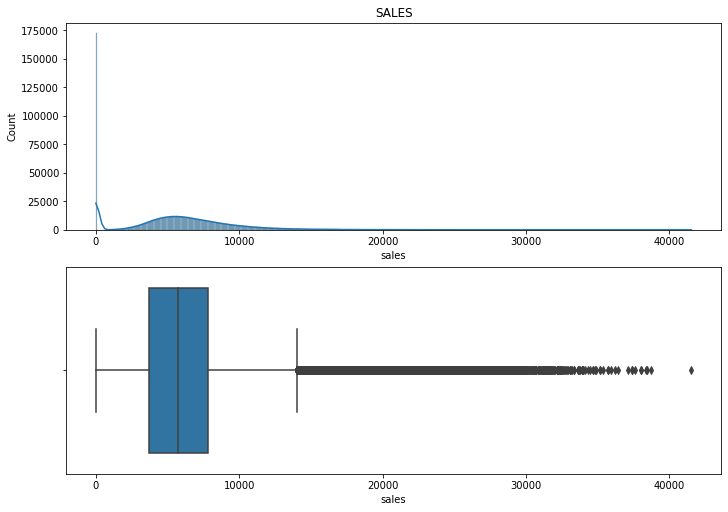

In [25]:
# check sales distribution
numerical_plot( df_num, 'sales')

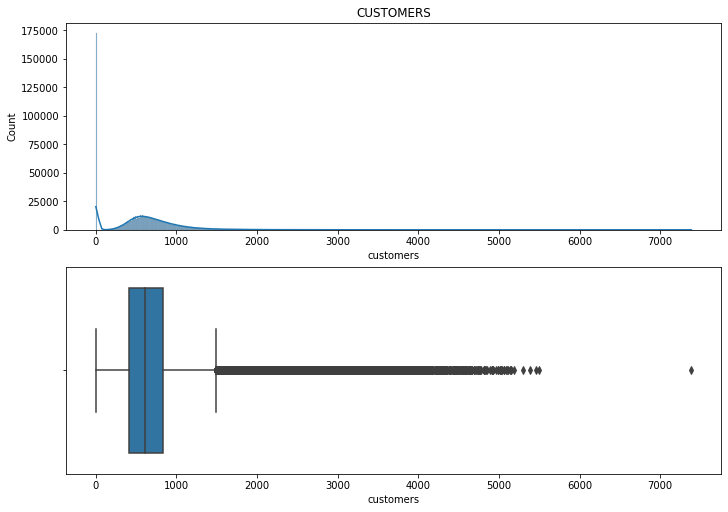

In [26]:
# check customers distribution
numerical_plot( df_num, 'customers');

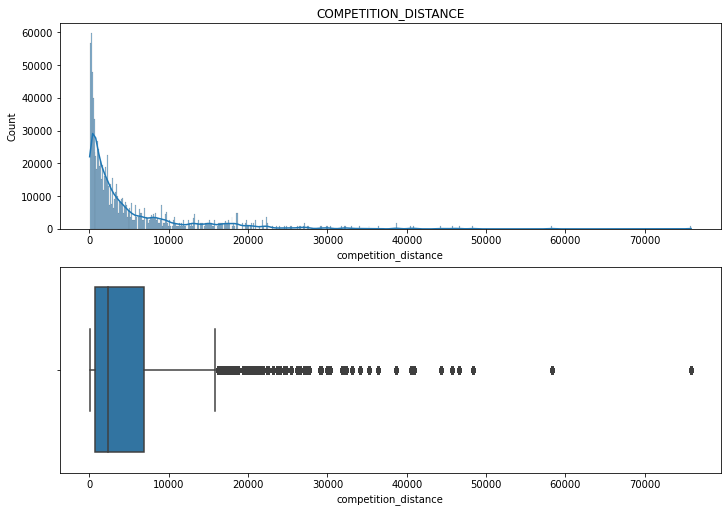

In [27]:
# check competition_distance distribution
numerical_plot( df_num, 'competition_distance');

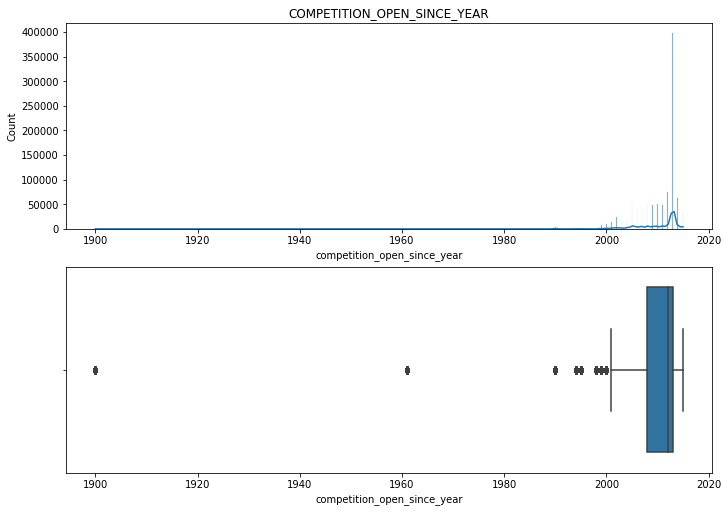

In [28]:
# check competition_open_since_year distribution
numerical_plot( df_num, 'competition_open_since_year');

### Categorical data

In [29]:
# check categorical dataframe
print( f'Categorical dataframe has {df_cat.shape} shape' )
df_cat.head()

Categorical dataframe has (1017209, 12) shape


,day_of_week,open,promo,state_holiday,school_holiday,store_type,assortment,promo2,promo_interval,competition_open_since_month,promo2_since_week,promo2_since_year
0,5,1,1,0,1,c,a,0,"Jan,Apr,Jul,Oct",9.0,14.0,2011.0
1,5,1,1,0,1,a,a,1,"Jan,Apr,Jul,Oct",11.0,13.0,2010.0
2,5,1,1,0,1,a,a,1,"Jan,Apr,Jul,Oct",12.0,14.0,2011.0
3,5,1,1,0,1,c,c,0,"Jan,Apr,Jul,Oct",9.0,14.0,2011.0
4,5,1,1,0,1,a,a,0,"Jan,Apr,Jul,Oct",4.0,14.0,2011.0


In [30]:
# number of unique values for every column
df_cat.apply( lambda x: x.unique() )

day_of_week                                                 [5, 4, 3, 2, 1, 7, 6]
open                                                                       [1, 0]
promo                                                                      [1, 0]
state_holiday                                                        [0, a, b, c]
school_holiday                                                             [1, 0]
store_type                                                           [c, a, d, b]
assortment                                                              [a, c, b]
promo2                                                                     [0, 1]
promo_interval                  [Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,Sep...
competition_open_since_month    [9.0, 11.0, 12.0, 4.0, 10.0, 8.0, 3.0, 6.0, 5....
promo2_since_week               [14.0, 13.0, 1.0, 45.0, 40.0, 26.0, 22.0, 5.0,...
promo2_since_year               [2011.0, 2010.0, 2012.0, 2009.0, 2014.0, 2015....
dtype: object

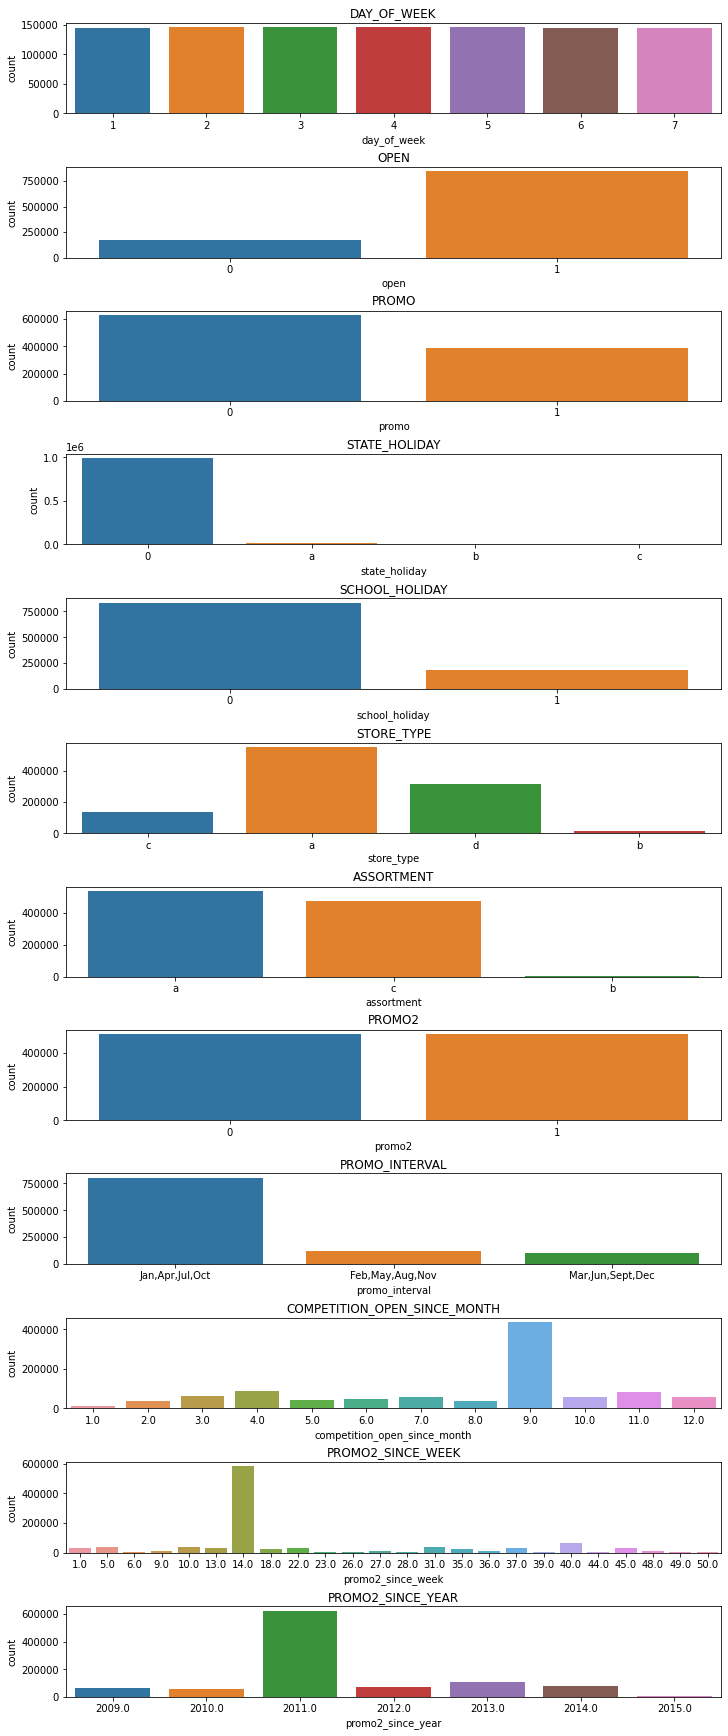

In [31]:
# create a figure object
fig = plt.figure( figsize = (10, 24), constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = df_cat.shape[1], figure = fig)

# iterate over column to plot countplot figure
for index, column in enumerate( df_cat.columns ):
    ax1 = fig.add_subplot( specs[index, 0] )
    ax1.set_title( column.upper() )
    sns.countplot( x = column, data = df_cat, ax = ax1 )

# FEATURE ENGINEERING

## Restore Point

In [32]:
# create a restore point for the previous section dataframe
df_f_eng = df_description.copy()
check_dataframe( df_f_eng )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0          0.0        1115   
day_of_week                            0          0.0           7   
date                                   0          0.0         942   
sales                                  0          0.0       21734   
customers                              0          0.0        4086   
open                                   0          0.0           2   
promo                                  0          0.0           2   
state_holiday                          0          0.0           4   
school_holiday                         0          0.0           2   
store_type                             0          0.0           4   
assortment                             0          0.0           3   
competition_distance                   0          0.0         654   
competition_open_since_month           0          0.0          12   
competition_open_since_year       

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,competition_open_since_month_NA,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA
755133,1064,6,2013-08-24,6427,775,1,0,0,0,a,...,2013.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1,1,1,1
148700,406,5,2015-03-20,6685,533,1,1,0,0,d,...,2001.0,1,10.0,2013.0,"Feb,May,Aug,Nov",0,0,0,0,0
989948,614,5,2013-01-25,5818,756,1,1,0,0,a,...,2012.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",0,0,1,1,1
289392,785,3,2014-11-05,7399,613,1,1,0,0,d,...,2005.0,1,31.0,2013.0,"Feb,May,Aug,Nov",0,0,0,0,0
176142,1088,2,2015-02-24,4745,451,1,0,0,0,a,...,2009.0,1,27.0,2013.0,"Jan,Apr,Jul,Oct",0,0,0,0,0


## Hypothesis Mind Map

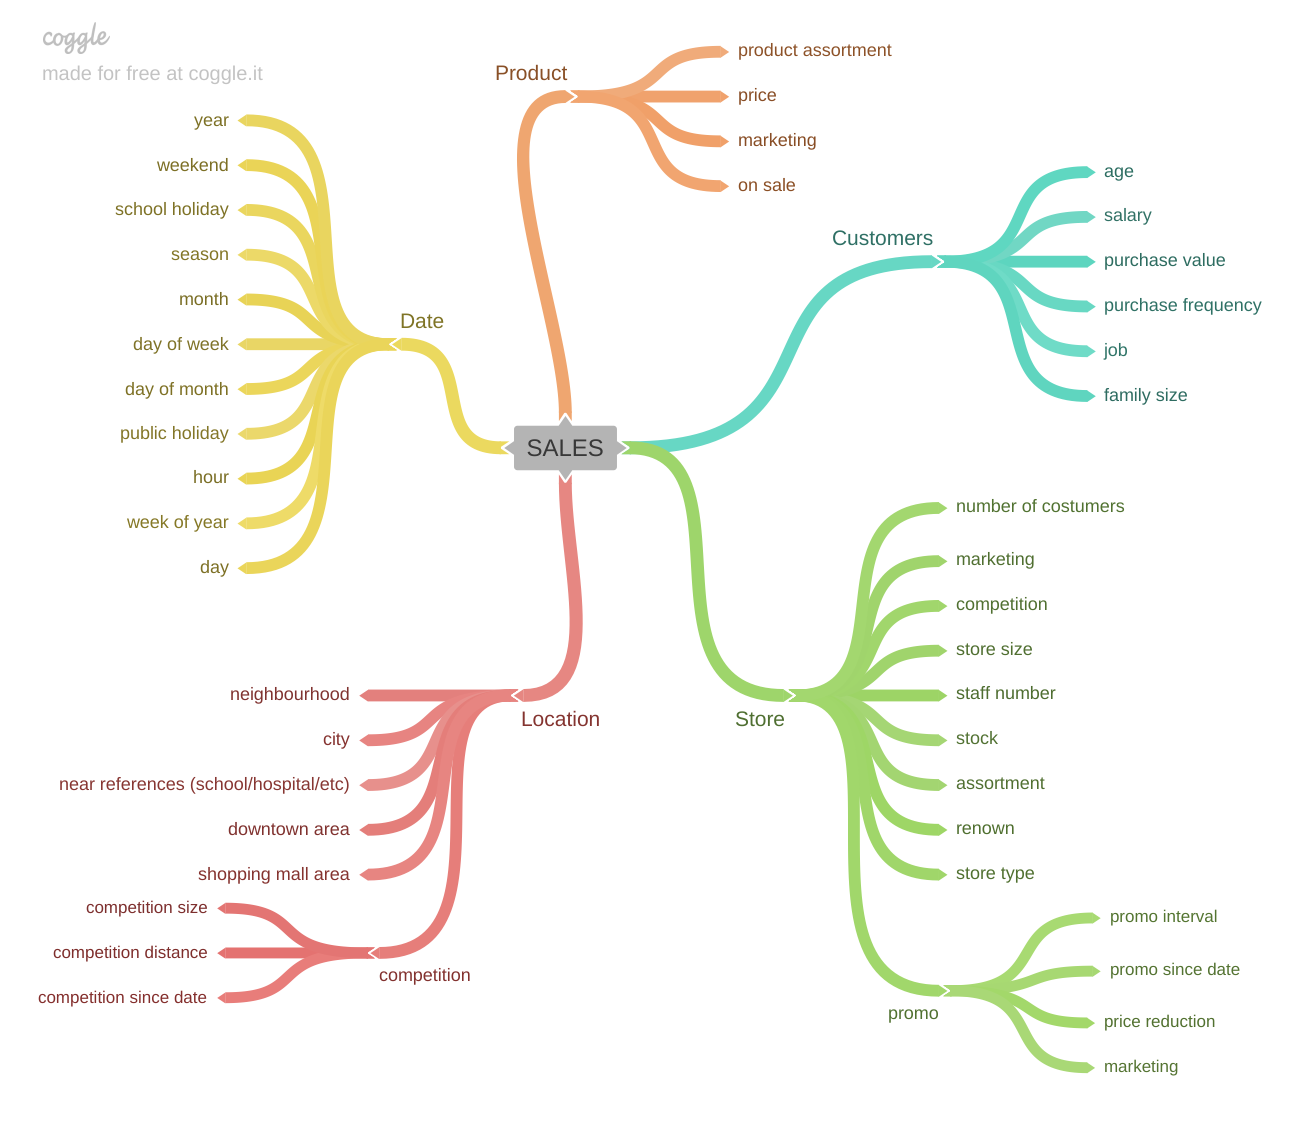

In [33]:
## Hypothesis mind map of store sales phenomenon
Image("../images/hypothesis_mind_map.png")

## Hypothesis Creation

### Product Hypothesis

**1.** Different product assortments have different sales revenue.

**2.** The lower the product price, the higher the sales revenue.

**3.** The more money is invested in product marketing, the higher the sales revenue.

**4.** If a product is on sale, the sales revenue increase.

### Customer Hypothesis

**1.** Sales revenue is higher for older customers.

**2.** Sales revenue is higher for higher customer salary.

**3.** The more expensive the customer purchase, the higher the sales revenue.

**4.** The more frequent a customer purchases, the higher the sales revenue.

**5.** Customers with different jobs contribute differently to sales revenue.

**6.** The larger the family size, the higher the sales revenue.

### Store Hypothesis

**1.** The more customers a store has, the higher the sales revenue.

**2.** The more money a company invests in marketing, the higher the sales revenue.

**3.** The more competitors a store has, the lower the sales revenue.

**4.** The larger the store size, the higher the sales revenue.

**5.** The larger the store staff, the higher the sales revenue.

**6.** The larger the store stock, the higher the sales revenue.

**7.** Different store assortments contribute differently to sales revenue.

**8.** The more renowned a store is, the higher the sales revenue.

**9.** Different store type has different sales revenue.

**10.** The longer the promo interval, the higher the sales revenue.

**11.** The earlier a promo starts, the higher the sales revenue.

**12.** The higher the price reduction on sales, the smaller the sales revenue.

**13.** The more money a store invests on promo marketing, the larger the sales revenue.

### Location Hypothesis

**1.** Different store neighbourhoods have different sales revenue.

**2.** Different store cities have different sales revenue.

**3.** The closer to a known reference (school/store/etc) a store is, the higher the sales revenue.

**4.** Stores in the downtown area have higher sales revenue.

**5.** Stores in shopping mall areas have higher sales revenue.

**6.** The bigger the competitors, the lower the sales revenue.

**7.** The nearer to competitors, the lower the sales revenue.

**8.** The earlier the competitors are opened, the lower the sales revenue.

### Date Hypothesis

**1.** Different years have different sales revenue.

**2.** The sales revenue is higher on weekends.

**3.** The sales revenue is lower on school holidays.

**4.** Different seasons have different sales revenues.

**5.** Different months have different sales revenues.

**6.** First days of the week have higher sales revenue.

**7.** First days of the month have higher sales revenue.

**8.** Public holidays have lower sales revenue.

**9.** Different hours of the day have different sales revenue.

**10** Last weeks of the year have higher sales revenue.

## Final Hypothesis List

> The chosen criterion for selecting the final hypothesis list:     
**availability of data to test a hypothesis**.

**1.** Different store assortments contribute differently to sales revenue.

**2.** The nearer to competitors, the lower the sales revenue.

**3.** The earlier the competitors were opened, the lower the sales revenue.

**4.** The earlier a promo starts, the higher the sales revenue.

**5.** Last weeks of the year have higher sales revenue.

**6.** Different years have different sales revenue.

**7.** Different months have different sales revenues.

**8.** First days of the month have higher sales revenue.

**9.** The sales revenue is higher on weekends.

**10.** Public holidays have lower sales revenue.

## Feature Engineering

In [34]:
# check dataframe
check_dataframe( df_f_eng )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0          0.0        1115   
day_of_week                            0          0.0           7   
date                                   0          0.0         942   
sales                                  0          0.0       21734   
customers                              0          0.0        4086   
open                                   0          0.0           2   
promo                                  0          0.0           2   
state_holiday                          0          0.0           4   
school_holiday                         0          0.0           2   
store_type                             0          0.0           4   
assortment                             0          0.0           3   
competition_distance                   0          0.0         654   
competition_open_since_month           0          0.0          12   
competition_open_since_year       

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,competition_open_since_month_NA,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA
260464,850,6,2014-12-06,5935,641,1,0,0,0,d,...,2007.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",0,0,0,0,0
440501,862,1,2014-06-02,11675,1497,1,1,0,0,a,...,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0,0,0,0,0
212025,176,4,2015-01-22,3922,578,1,0,0,0,a,...,2013.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1,1,1,1
697772,568,1,2013-10-14,3997,369,1,0,0,1,d,...,2013.0,1,1.0,2013.0,"Jan,Apr,Jul,Oct",1,1,0,0,0
844607,223,2,2013-06-04,7519,777,1,1,0,0,d,...,1995.0,1,27.0,2011.0,"Jan,Apr,Jul,Oct",0,0,0,0,0


In [35]:
# convert float columns to integer columns 
# as they have interger values
df_f_eng['competition_distance'] = df_f_eng['competition_distance'].astype( int )
df_f_eng['competition_open_since_month'] = df_f_eng['competition_open_since_month'].astype( int )
df_f_eng['competition_open_since_year'] = df_f_eng['competition_open_since_year'].astype( int )
df_f_eng['promo2_since_week'] = df_f_eng['promo2_since_week'].astype( int )
df_f_eng['promo2_since_year'] = df_f_eng['promo2_since_year'].astype( int )

In [36]:
# create a column for day of month
df_f_eng['day_of_month'] = df_f_eng['date'].dt.day

# create day of year
df_f_eng['day_of_year'] = df_f_eng['date'].dt.strftime('%j')
df_f_eng['day_of_year'] = df_f_eng['day_of_year'].astype( 'int' )

# create a column for month
df_f_eng['month'] = df_f_eng['date'].dt.month

# create a column for year
df_f_eng['year'] = df_f_eng['date'].dt.year

# make day_of_week start from 0 -> (sunday = 0)
df_f_eng['day_of_week'] = df_f_eng['day_of_week'].apply( lambda x: 0 if x == 7 else x )

# create a column for week number 
# sunday = 0 to match day_of_week column
df_f_eng['week_number'] = df_f_eng['date'].dt.strftime('%U')
df_f_eng['week_number'] = df_f_eng['week_number'].astype( 'int' );

In [37]:
# get season data
spring = range(3, 5)
summer = range(6, 8)
autumn = range(9, 11)
# winter = everything else

# create season column
df_f_eng['season'] = df_f_eng['month'].apply( lambda x: 'spring' if x in spring else
                                                       'summer' if x in summer else
                                                       'autumn' if x in autumn else
                                                       'winter')

# DATA FILTERING

## Restore Point

In [38]:
# create a restore point for the previous section dataframe
df_filtering = df_f_eng.copy()

# check dataframe
check_dataframe( df_filtering )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0          0.0        1115   
day_of_week                            0          0.0           7   
date                                   0          0.0         942   
sales                                  0          0.0       21734   
customers                              0          0.0        4086   
open                                   0          0.0           2   
promo                                  0          0.0           2   
state_holiday                          0          0.0           4   
school_holiday                         0          0.0           2   
store_type                             0          0.0           4   
assortment                             0          0.0           3   
competition_distance                   0          0.0         654   
competition_open_since_month           0          0.0          12   
competition_open_since_year       

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA,day_of_month,day_of_year,month,year,week_number,season
314422,523,4,2014-10-09,12971,1518,1,1,0,0,c,...,0,1,1,1,9,282,10,2014,40,autumn
235658,394,4,2015-01-01,0,0,0,0,a,1,d,...,1,1,1,1,1,1,1,2015,0,winter
963690,1,0,2013-02-17,0,0,0,0,0,0,c,...,0,1,1,1,17,48,2,2013,7,winter
11679,530,2,2015-07-21,7985,1396,1,0,0,1,a,...,1,1,1,1,21,202,7,2015,29,summer
53611,92,6,2015-06-13,6189,528,1,0,0,0,c,...,1,0,0,0,13,164,6,2015,23,summer


## Rows Filtering

In [39]:
# remove rows where store is closed
df_filtering = df_filtering[ df_filtering['open'] == 1 ]

## Columns Selection

In [40]:
# remove open column
df_filtering.drop(columns = ['open'], 
                  axis = 'columns',
                  inplace = True)

# EXPLORATORY DATA ANALYSIS

## Restore point

In [41]:
# create a restore point for the previous section dataframe
df_eda = df_filtering.copy()

# check dataframe
check_dataframe( df_eda )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0          0.0        1115   
day_of_week                            0          0.0           7   
date                                   0          0.0         942   
sales                                  0          0.0       21734   
customers                              0          0.0        4086   
promo                                  0          0.0           2   
state_holiday                          0          0.0           4   
school_holiday                         0          0.0           2   
store_type                             0          0.0           4   
assortment                             0          0.0           3   
competition_distance                   0          0.0         654   
competition_open_since_month           0          0.0          12   
competition_open_since_year            0          0.0          23   
promo2                            

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,...,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA,day_of_month,day_of_year,month,year,week_number,season
921453,134,3,2013-03-27,5815,562,1,0,1,a,a,...,0,1,1,1,27,86,3,2013,12,spring
90889,575,1,2015-05-11,4299,458,0,0,0,a,a,...,0,0,0,0,11,131,5,2015,19,winter
228965,391,3,2015-01-07,5797,672,1,0,0,a,a,...,0,0,0,0,7,7,1,2015,1,winter
755738,554,5,2013-08-23,3438,439,0,0,0,c,c,...,1,1,1,1,23,235,8,2013,33,winter
679351,1102,4,2013-10-31,7655,827,0,0,1,a,a,...,0,0,0,0,31,304,10,2013,43,autumn


## Univariate Analysis

### Response Variable

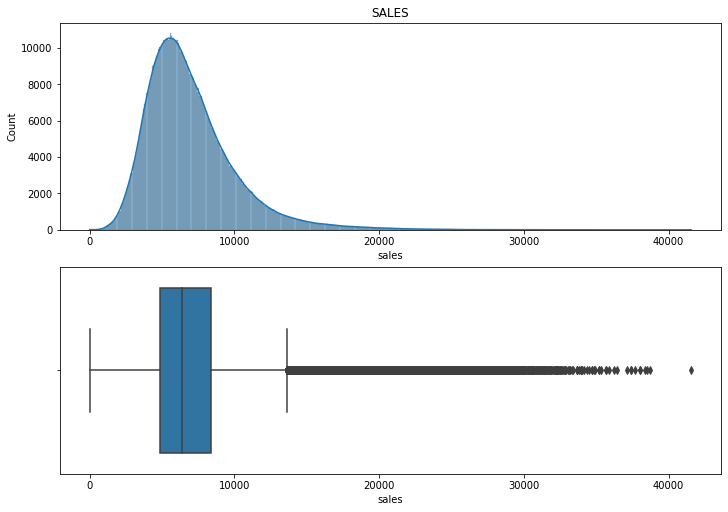

In [42]:
# plot response variable
numerical_plot( df_eda, 'sales' )

### Date Variables

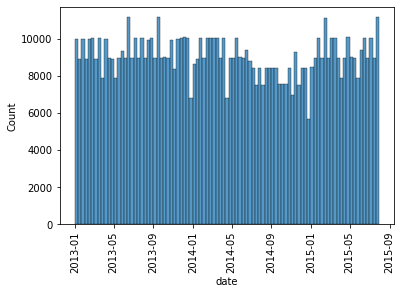

In [43]:
# select date features
date_features = df_eda['date']

# plot date data
sns.histplot( x = date_features)
plt.xticks( rotation = 90 );

### Numerical Variables

In [44]:
# select numerical features
df_num_features = df_eda[['store',
                          'customers',
                          'competition_distance',
                          'day_of_year'
                         ]]

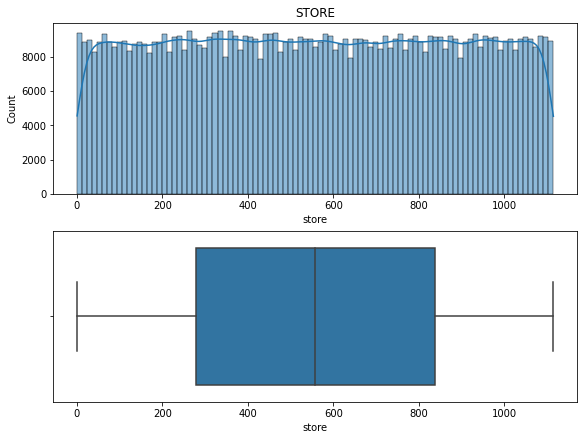

In [45]:
# plot store feature
numerical_plot(df_num_features, 'store', figsize = (8,6) )

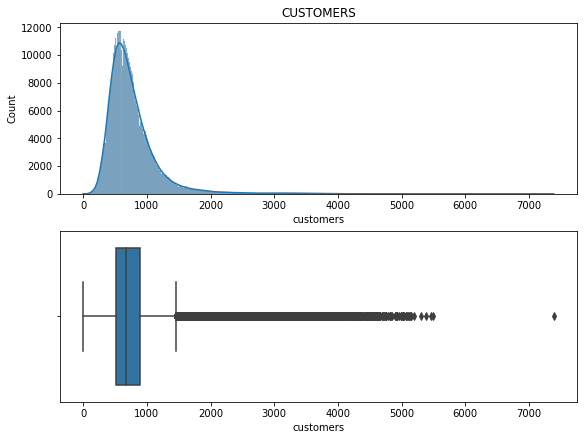

In [46]:
# plot customers feature
numerical_plot(df_num_features, 'customers', figsize = (8,6) )

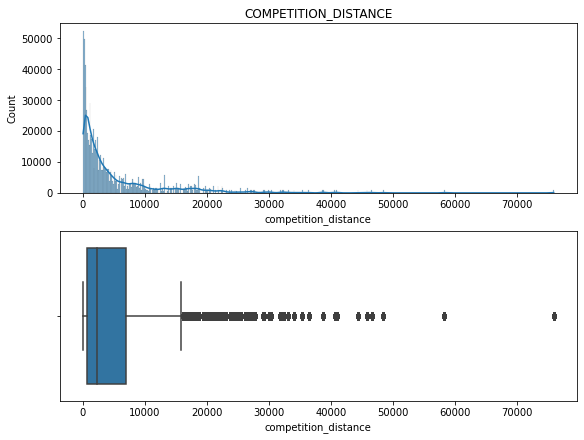

In [47]:
# plot competition_distance feature
numerical_plot(df_num_features, 'competition_distance', figsize = (8,6) )

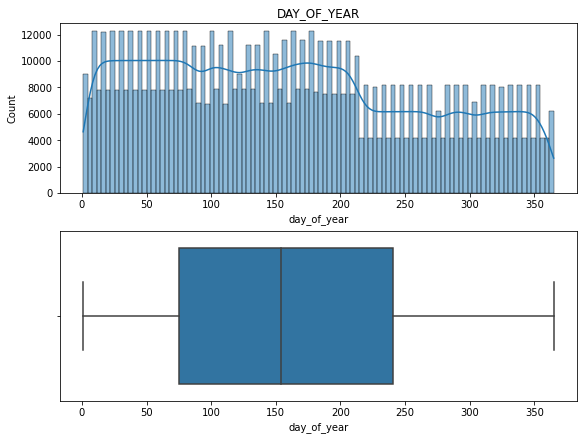

In [48]:
# plot day_of_year feature
numerical_plot(df_num_features, 'day_of_year', figsize = (8,6) )

In [49]:
# calculate summary statistics
numerical_statistics( df_num_features )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,store,558.422920,558.0,321.731724,1.0,1115.0,1114.0,0.000414,-1.198841
1,customers,762.728395,676.0,401.227437,0.0,7388.0,7388.0,2.788110,13.313755
2,competition_distance,5449.881773,2330.0,7800.936902,20.0,75860.0,75840.0,2.980061,13.454756
3,day_of_year,162.386520,154.0,101.367836,1.0,365.0,364.0,0.268853,-1.025905


### Categorical Variables

In [50]:
# select numerical features
df_cat_features = df_eda[['day_of_week',
                          'promo',
                          'state_holiday',
                          'school_holiday',
                          'store_type',
                          'assortment',
                          'competition_open_since_month',
                          'competition_open_since_year',
                          'promo2',
                          'promo2_since_week',
                          'promo2_since_year',
                          'promo_interval',
                          'day_of_month',
                          'month',
                          'season',
                          'year',
                          'week_number',
                          'competition_open_since_month_NA',
                          'competition_open_since_year_NA',
                          'promo2_since_week_NA',
                          'promo2_since_year_NA',
                          'promo_interval_NA'  
                        ]]

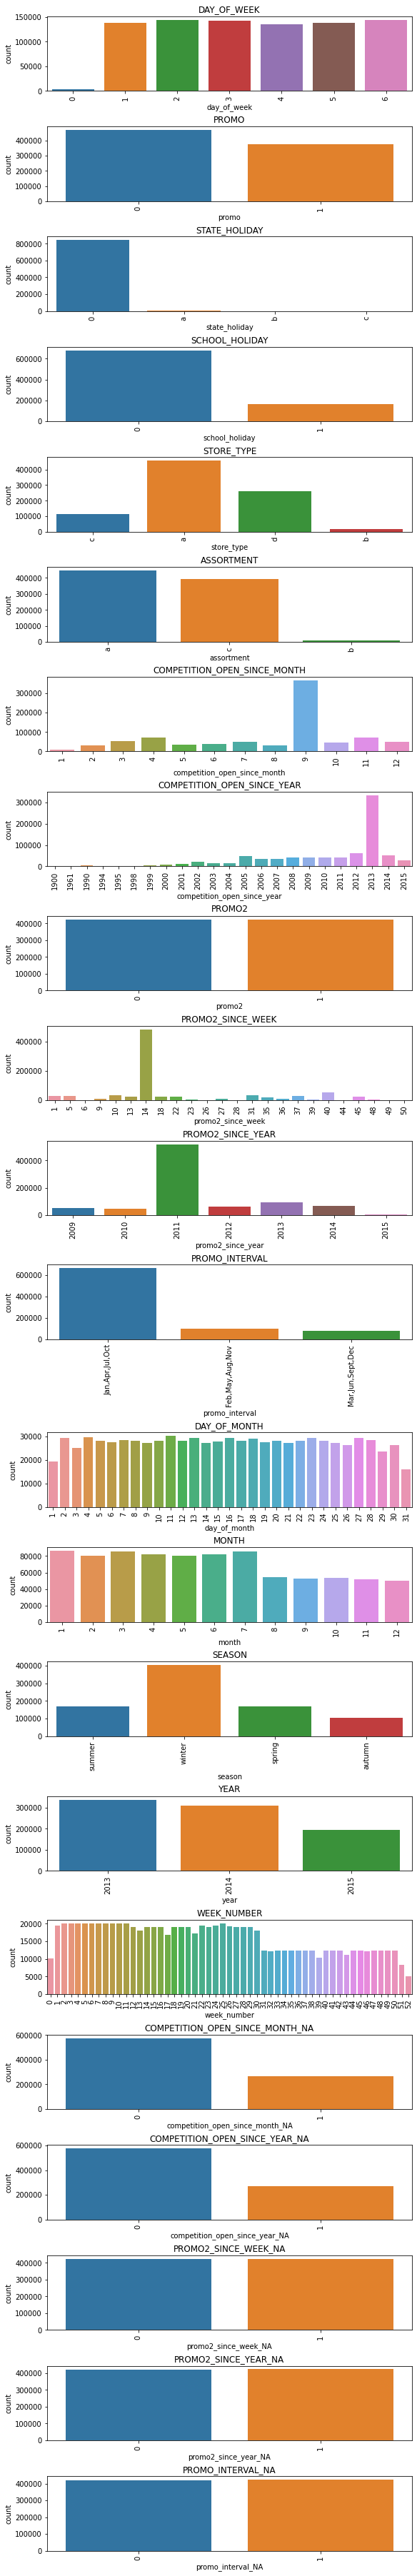

In [51]:
# create a figure object
fig = plt.figure( figsize =(8,50), constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = df_cat_features.shape[1], figure = fig)

# iterate over each categorical feature
for index, col in enumerate( df_cat_features.columns ):
    # create axs
    ax_x = fig.add_subplot( specs[index, 0] )
    # plot countplot on axs
    sns.countplot( data = df_cat_features, 
                   x = col, 
                   ax = ax_x )
    # set title
    plt.title( col.upper() )
    # rotate x label
    plt.xticks( rotation = 90 )

## Bivariate Analysis

### **H1.** Different store assortments contribute differently to sales revenue.

> **H1 IS TRUE**. Different store assortments contribute differently to sales revenue and 'extra' assortment has higher median sales.

In [52]:
# map assortment column according to database information
# Assortment -> a = basic, b = extra, c = extended
df_eda['assortment'] = df_eda['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                            'extra' if x == 'b' else
                                                            'extended'
                                                 )

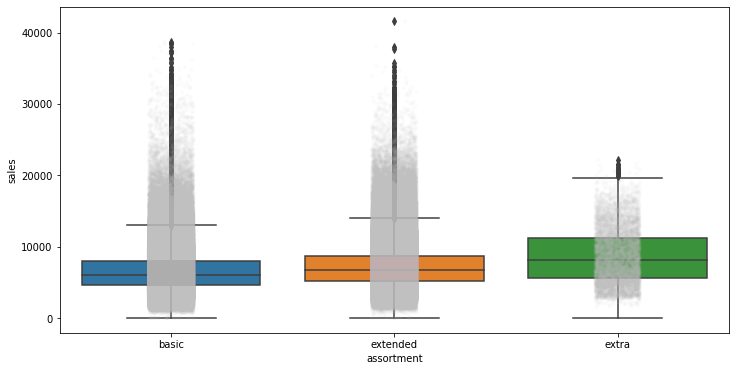

In [53]:
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'assortment', data = df_eda, ax = ax )
sns.stripplot(y = 'sales',  x = 'assortment', data = df_eda, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

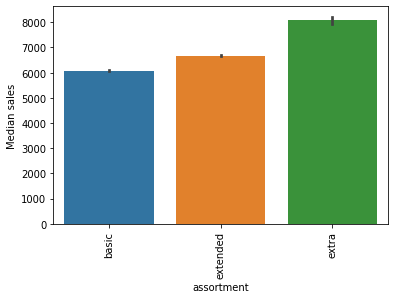

In [54]:
# plot bar chart
sns.barplot( x = 'assortment', y = 'sales',
             data = df_eda, estimator = np.median )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### **H2.** The nearer to competitors, the lower the sales revenue.

> **H2 IS FALSE**. The nearer to competitors, the higher the sales revenue tends to be.

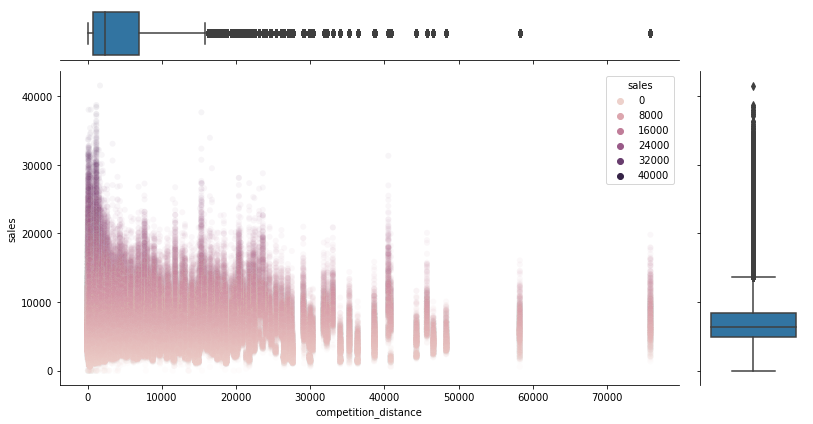

In [55]:
# competition_distance had its NA values filled with the median value.
# However, once missing values was less than 0.3% of total observations,
# we don't need to reverse inputation to analyse the behavior between 
# this variable and the response variable
# prepare grid
g = sns.JointGrid(data = df_eda, x = 'competition_distance', y = 'sales',
                  hue = 'sales')
# set figure dimensions
g.fig.set_size_inches(12, 6)
# plot scatterplot of main figure
g.plot_joint( sns.scatterplot, alpha = 0.05 )
# plot boxplot on marginals
g.plot_marginals( sns.boxplot );

### **H3.** The earlier the competitors were opened, the lower the sales revenue.

> **H3 IS FALSE**. The earlier the competitors were opened, the higher the median sales revenue tends to be.

In [56]:
# once competition_open_since_year had its NA values filled with 
# the most frequent category, we need to reverse inputation to 
# correctly analyse the behavior between these variables and
# the response variable
df_aux = reverse_inputation( df_eda, 'competition_open_since_year', 
                             'competition_open_since_year_NA', 'sales', 
                             response = True, reverse_inputter = 1900 )
df_aux.tail()

,competition_open_since_year,competition_open_since_year_NA,sales
1016776,2006,0,3375
1016827,1999,0,10765
1016863,1900,1,5035
1017042,1900,1,4491
1017190,2002,0,5961


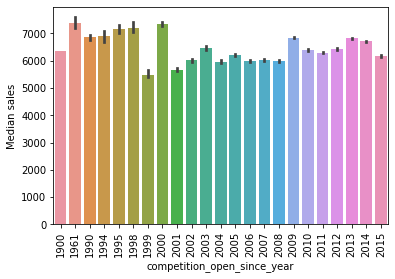

In [57]:
# NOTE: remember that 1900 is a missing value
# plot bar chart
sns.barplot( x = 'competition_open_since_year', y = 'sales',
             data = df_aux, estimator = np.median )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

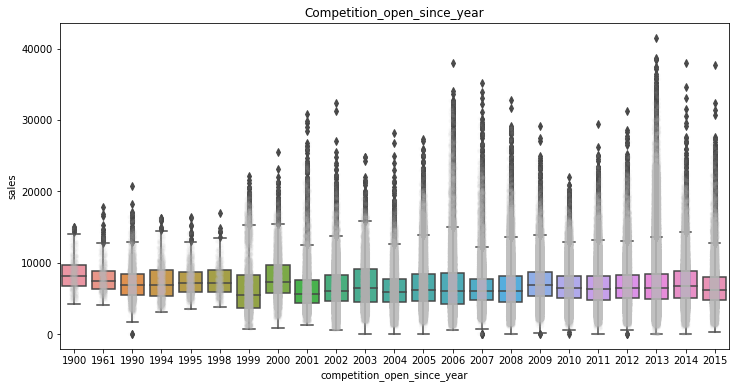

In [58]:
# NOTE: remember that 1900 is a missing value
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'competition_open_since_year', data = df_eda, ax = ax )
sns.stripplot(y = 'sales',  x = 'competition_open_since_year', data = df_eda, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);
plt.title( 'Competition_open_since_year' );

### **H4.** The earlier a promo starts, the higher the sales revenue.

> **H4 IS FALSE**. For continue and consecutive promos, there is no clear relation between the earlier the promo started and the sales revenue.

In [59]:
# once promo2_since_week had its NA values filled with the most frequent category,
# we need to reverse inputation to correctly analyse the behavior 
# between this promo2_since_week and the response variable
df_aux = reverse_inputation( df_eda, 'promo2_since_week', 
                             'promo2_since_week_NA', 'sales', 
                              reverse_inputter = 99, response = True )
df_aux.tail()

,promo2_since_week,promo2_since_week_NA,sales
1016776,99,1,3375
1016827,99,1,10765
1016863,48,0,5035
1017042,99,1,4491
1017190,99,1,5961


In [60]:
# order according to promo2_since_week
df_aux = df_aux.sort_values('promo2_since_week')

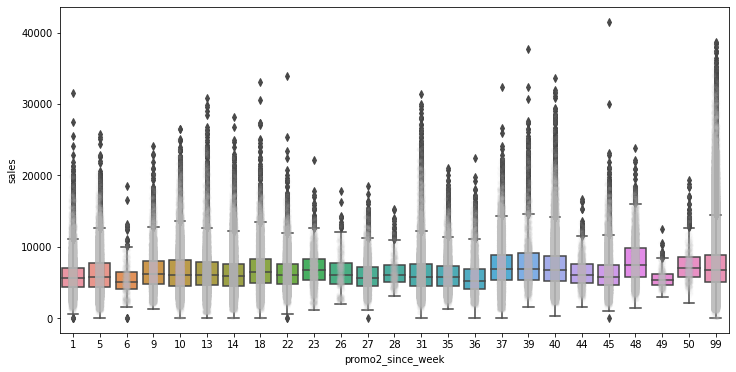

In [61]:
# NOTE: 99 is a unkown value
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'promo2_since_week', data = df_aux, ax = ax )
sns.stripplot(y = 'sales',  x = 'promo2_since_week', data = df_aux, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

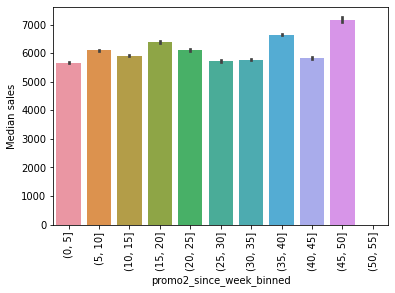

In [62]:
# bins: start, end, interval range
bins = list( np.arange( 0, 60, 5) )
# create a binned column
df_aux['promo2_since_week_binned'] = pd.cut( df_aux['promo2_since_week'], 
                                             bins = bins )

# plot bar chart
sns.barplot( x = 'promo2_since_week_binned', y = 'sales',
             data = df_aux, estimator = np.median )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

In [63]:
# once promo2_since_year had its NA values filled with the most frequent category,
# we need to reverse inputation to correctly analyse the behavior 
# between this promo2_since_year and the response
df_aux = reverse_inputation( df_eda, 'promo2_since_year', 
                             'promo2_since_year_NA', 'sales', 
                             response = True, reverse_inputter = 1900 )
df_aux.tail()

,promo2_since_year,promo2_since_year_NA,sales
1016776,1900,1,3375
1016827,1900,1,10765
1016863,2012,0,5035
1017042,1900,1,4491
1017190,1900,1,5961


In [64]:
# order according to promo2_since_week
df_aux = df_aux.sort_values('promo2_since_year')

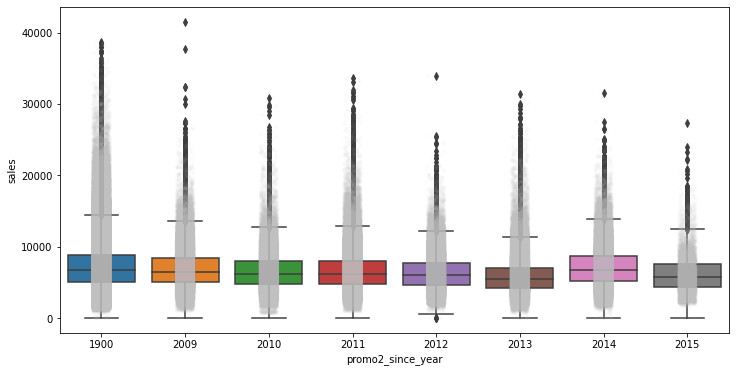

In [65]:
# NOTE: 1900 is a unkown value
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'promo2_since_year', data = df_aux, ax = ax )
sns.stripplot(y = 'sales',  x = 'promo2_since_year', data = df_aux, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

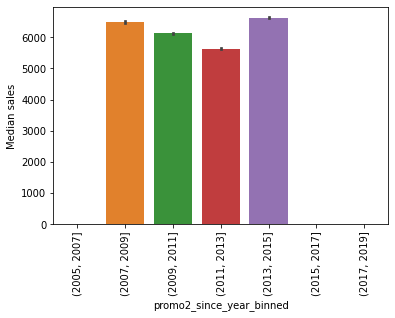

In [66]:
# bins: start, end, interval range
bins = list( np.arange( 2005, 2020, 2) )
# create a binned column
df_aux['promo2_since_year_binned'] = pd.cut( df_aux['promo2_since_year'], 
                                             bins = bins )

# plot bar chart
sns.barplot( x = 'promo2_since_year_binned', y = 'sales',
             data = df_aux, estimator = np.median )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### H5. Last weeks of the year have higher sales revenue.

> **H5 IS TRUE**. The best week for the sales revenue is week 50 and the last weeks of the year tend to have a higher sales revenue median.

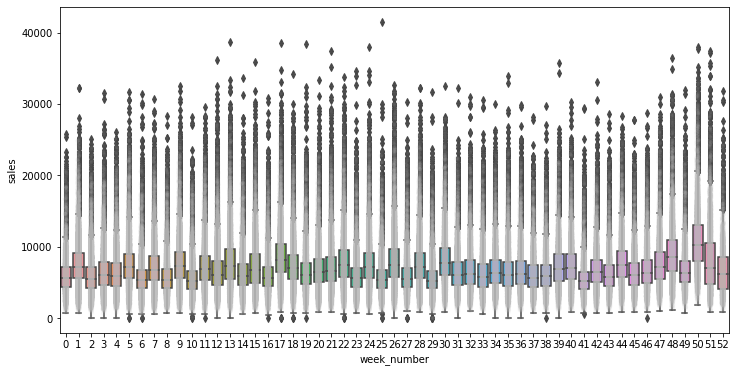

In [67]:
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'week_number', data = df_eda, ax = ax )
sns.stripplot(y = 'sales',  x = 'week_number', data = df_eda, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

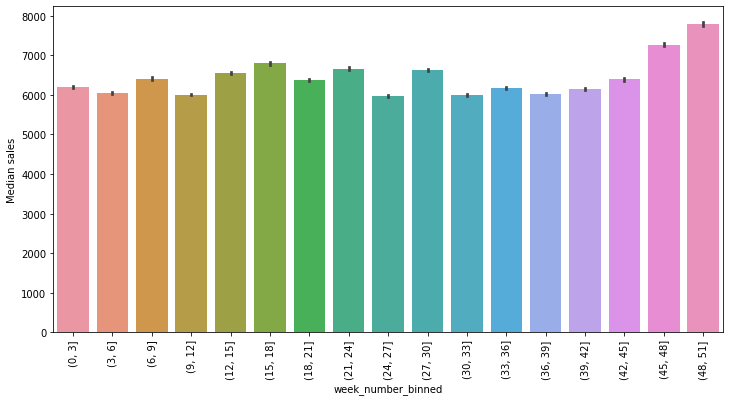

In [68]:
# In the case you need to bins the x-axis to help analyse
# bins: start (included), end (not included), interval range
bins = list( np.arange( 0, 53, 3) )
# create a auxiliary dataframe
df_aux = df_eda[ ['week_number', 'sales'] ].copy()
# create a binned column
df_aux['week_number_binned'] = pd.cut( df_aux['week_number'], bins = bins )

# plot bar chart
fig, ax = plt.subplots( figsize=(12, 6) )
sns.barplot( x = 'week_number_binned', y = 'sales',
             data = df_aux, estimator = np.median, ax = ax )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### **H6.** Different years have different sales revenue.

> **H6 IS FALSE**. There is no significant difference in the median sales revenue for different years.

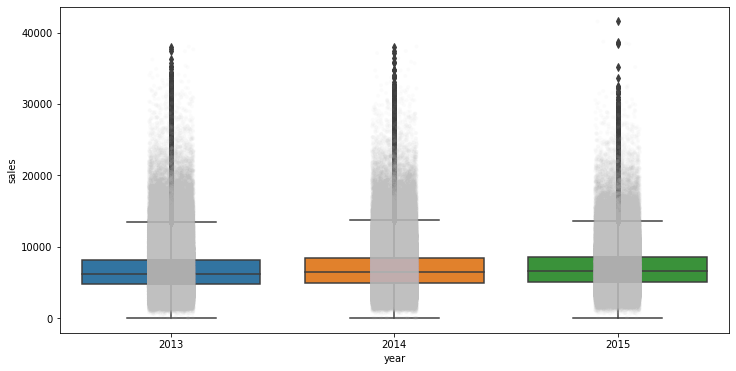

In [69]:
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'year', data = df_eda, ax = ax )
sns.stripplot(y = 'sales',  x = 'year', data = df_eda, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

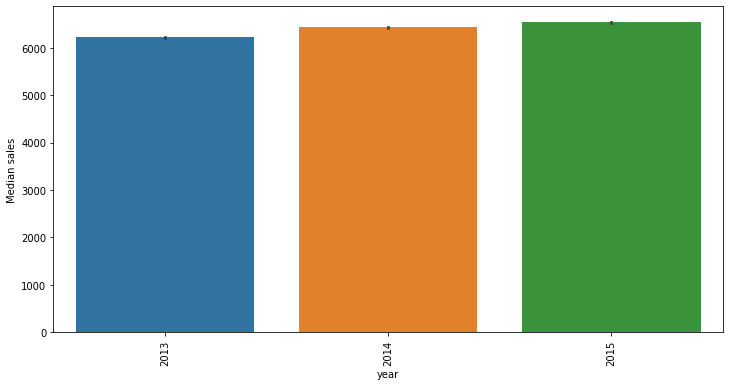

In [70]:
# plot bar chart
fig, ax = plt.subplots( figsize=(12, 6) )
sns.barplot( x = 'year', y = 'sales',
             data = df_eda, estimator = np.median, ax = ax )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### **H7.** Different months have different sales revenues.

> **H7 IS TRUE**. Different months have different median sales revenue. However, except for November and December (higher median sales revenue), the remaining months have similar median sales revenue.

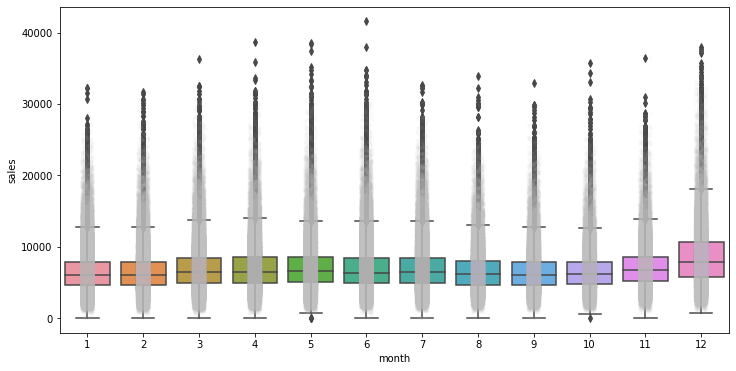

In [71]:
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'month', data = df_eda, ax = ax )
sns.stripplot(y = 'sales',  x = 'month', data = df_eda, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

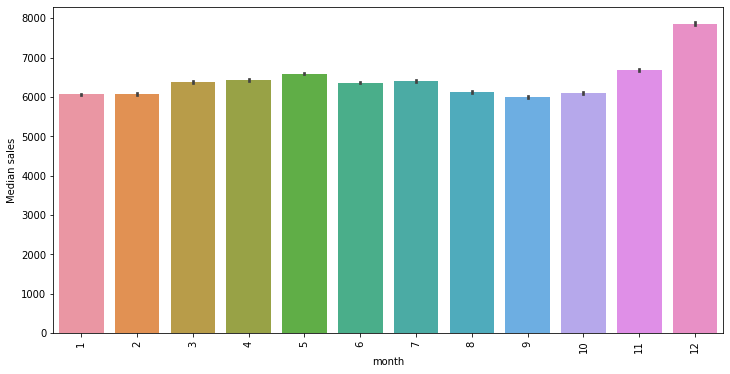

In [72]:
# plot bar chart
fig, ax = plt.subplots( figsize=(12, 6) )
sns.barplot( x = 'month', y = 'sales',
             data = df_eda, estimator = np.median, ax = ax )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### **H8.** First days of the month have higher sales revenue.

> **H8 IS TRUE**. The median sales revenue for the first day of the month is higher than for the remaining days. However, the day with the highest median sales revenue is the 30th day of the month.

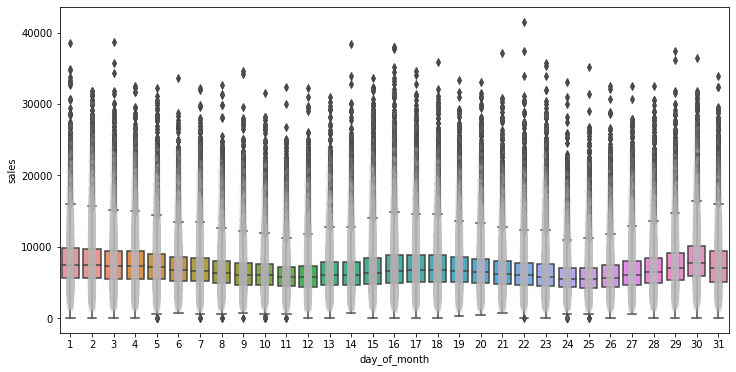

In [73]:
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'day_of_month', data = df_eda, ax = ax )
sns.stripplot(y = 'sales',  x = 'day_of_month', data = df_eda, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

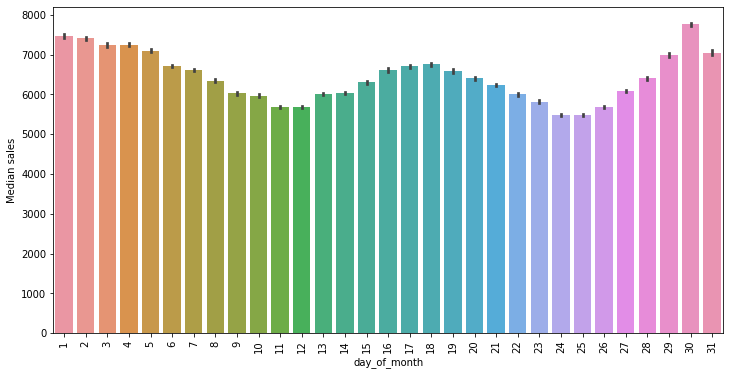

In [74]:
# plot bar chart
fig, ax = plt.subplots( figsize=(12, 6) )
sns.barplot( x = 'day_of_month', y = 'sales',
             data = df_eda, estimator = np.median, ax = ax )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### **H9.** The sales revenue is higher on weekends.

> **H9 IS FALSE**. From Monday till Thursday, the sales revenue is higher than from Friday till Sunday.

In [75]:
# create auxiliary dataframe to map day_of_week
df_aux = df_eda[ ['day_of_week', 'sales'] ].copy()
df_aux['day_of_week'] = df_aux['day_of_week'].apply( lambda x: 'weekend' if x in [5, 6, 7] else
                                            'weekday')
print( df_aux['day_of_week'].unique() )
df_aux.head()

['weekend' 'weekday']


,day_of_week,sales
0,weekend,5263
1,weekend,6064
2,weekend,8314
3,weekend,13995
4,weekend,4822


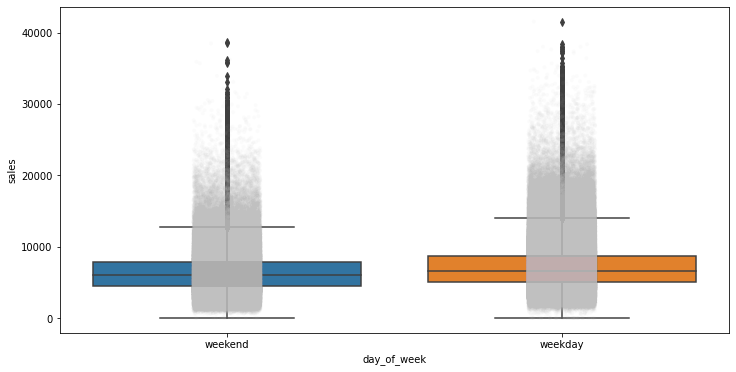

In [76]:
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'day_of_week', data = df_aux, ax = ax )
sns.stripplot(y = 'sales',  x = 'day_of_week', data = df_aux, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

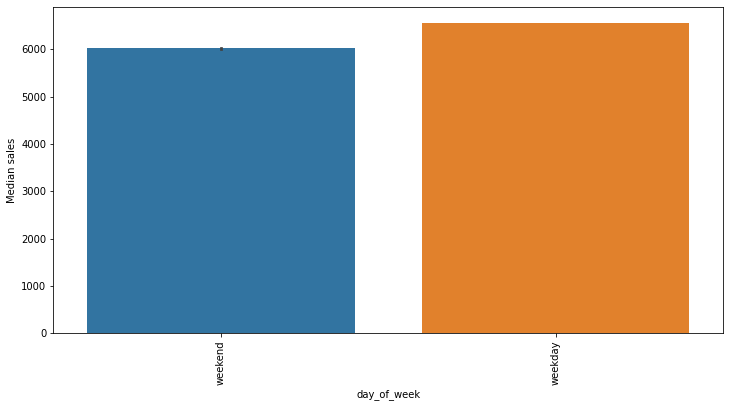

In [77]:
# plot bar chart
fig, ax = plt.subplots( figsize=(12, 6) )
sns.barplot( x = 'day_of_week', y = 'sales',
             data = df_aux, estimator = np.median, ax = ax )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

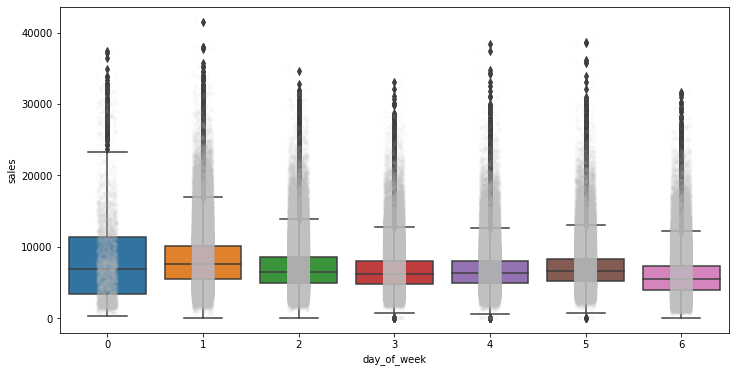

In [78]:
# plot boxplot with striplot overlay
# monday is 1
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'day_of_week', data = df_eda, ax = ax )
sns.stripplot(y = 'sales',  x = 'day_of_week', data = df_eda, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

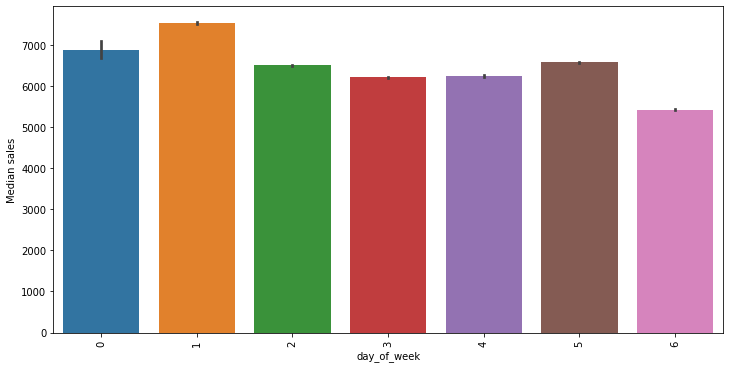

In [79]:
# plot bar chart
fig, ax = plt.subplots( figsize=(12, 6) )
sns.barplot( x = 'day_of_week', y = 'sales',
             data = df_eda, estimator = np.median, ax = ax )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### **H10.** Public holidays have lower sales revenue.

> **H10 IS FALSE**. The sales revenue is higher on public holidays, especially on Easter and Christmas.

In [80]:
# according to dataset information
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
# create auxiliary dataframe to map state_holiday
df_aux = df_eda[ ['state_holiday', 'sales'] ].copy()
df_aux['state_holiday'] = df_aux['state_holiday'].apply( lambda x: 
                                                        'Public' if x == 'a' else
                                                        'Easter' if x == 'b' else
                                                        'Christmas' if x == 'c' else
                                                        'None'
                                                       )
print( df_aux['state_holiday'].unique() )
df_aux.head()

['None' 'Public' 'Easter' 'Christmas']


,state_holiday,sales
0,None,5263
1,None,6064
2,None,8314
3,None,13995
4,None,4822


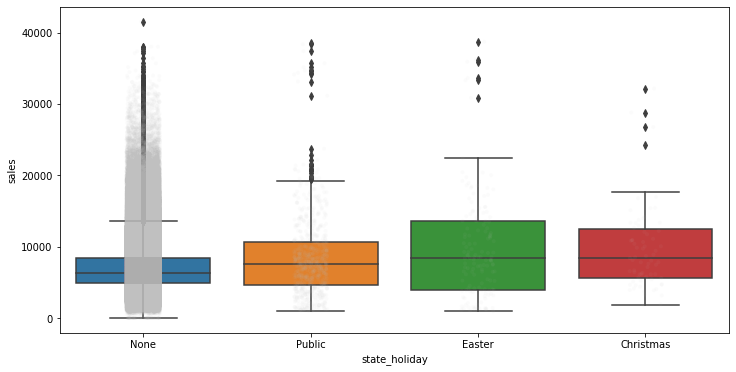

In [81]:
# plot boxplot with striplot overlay
fig, ax = plt.subplots( figsize=(12, 6) )
sns.boxplot(y = 'sales',  x = 'state_holiday', data = df_aux, ax = ax )
sns.stripplot(y = 'sales',  x = 'state_holiday', data = df_aux, 
              size = 4, color='silver', alpha = 0.05, ax = ax, jitter = True);

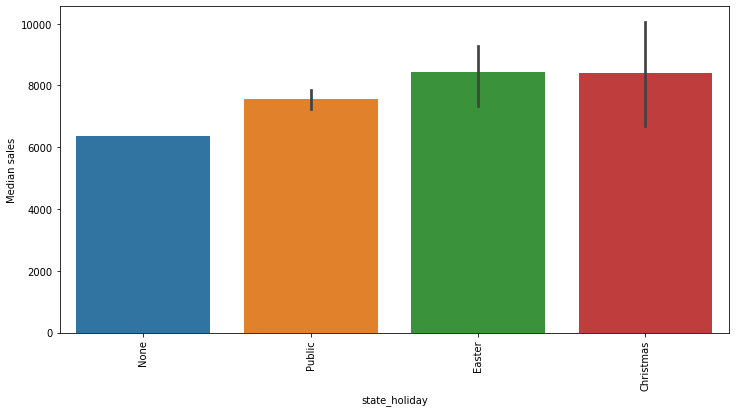

In [82]:
# plot bar chart
fig, ax = plt.subplots( figsize=(12, 6) )
sns.barplot( x = 'state_holiday', y = 'sales',
             data = df_aux, estimator = np.median, ax = ax )
plt.ylabel( 'Median sales' )
plt.xticks( rotation = 90 );

### Remaining variables

In [83]:
# columns already analysed
cols_to_drop = ['assortment', 
                'competition_distance',
                'competition_open_since_year',
                'competition_open_since_month',
                'promo2_since_week',
                'promo2_since_year',
                'week_number',
                'year',
                'month',
                'day_of_month',
                'day_of_week',
                'state_holiday', 
                'store', 
               ] 
    
# create auxiliary dataframe
df_aux = df_eda.copy()

# remove analysed columns from auxiliary dataframe
df_aux.drop( columns = cols_to_drop, axis = 'columns', inplace = True )
df_aux.head()

,date,sales,customers,promo,school_holiday,store_type,promo2,promo_interval,competition_open_since_month_NA,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA,day_of_year,season
0,2015-07-31,5263,555,1,1,c,0,"Jan,Apr,Jul,Oct",0,0,1,1,1,212,summer
1,2015-07-31,6064,625,1,1,a,1,"Jan,Apr,Jul,Oct",0,0,0,0,0,212,summer
2,2015-07-31,8314,821,1,1,a,1,"Jan,Apr,Jul,Oct",0,0,0,0,0,212,summer
3,2015-07-31,13995,1498,1,1,c,0,"Jan,Apr,Jul,Oct",0,0,1,1,1,212,summer
4,2015-07-31,4822,559,1,1,a,0,"Jan,Apr,Jul,Oct",0,0,1,1,1,212,summer


In [84]:
# numerical features
aux_num_features = ['customers', 'day_of_year']

# categorical features
aux_cat_features = ['promo', 
                    'school_holiday', 
                    'store_type', 
                    'promo2',
                    'promo_interval', 
                    'competition_open_since_month_NA',
                    'competition_open_since_year_NA',
                    'promo2_since_week_NA', 
                    'promo2_since_year_NA',
                    'promo_interval_NA', 
                    'season'
                      ]

#### Date variable

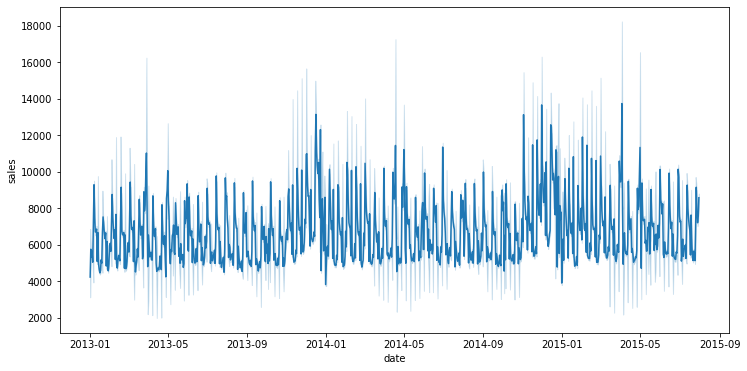

In [85]:
# plot line plot
fig, ax = plt.subplots( figsize=(12, 6) )
sns.lineplot( data = df_eda, x = 'date', y = 'sales',
              estimator = np.median, err_style = 'band', ax = ax );

#### Numeric variables

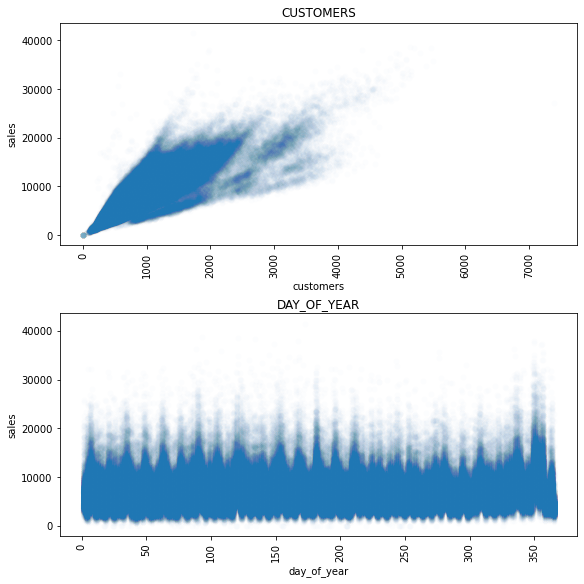

In [86]:
# create a figure object
fig = plt.figure( figsize =(8,8), constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = len(aux_num_features), figure = fig)

# iterate over each remaining numerical feature
for index, col in enumerate( aux_num_features ):
    # plot scatter plot
    ax_scatter = fig.add_subplot( specs[index, 0] )
    sns.scatterplot( data = df_eda, x = col, y = 'sales', ax = ax_scatter, alpha = 0.01 )
    plt.title( col.upper() )
    plt.xticks( rotation = 90 )

#### Categorical variables

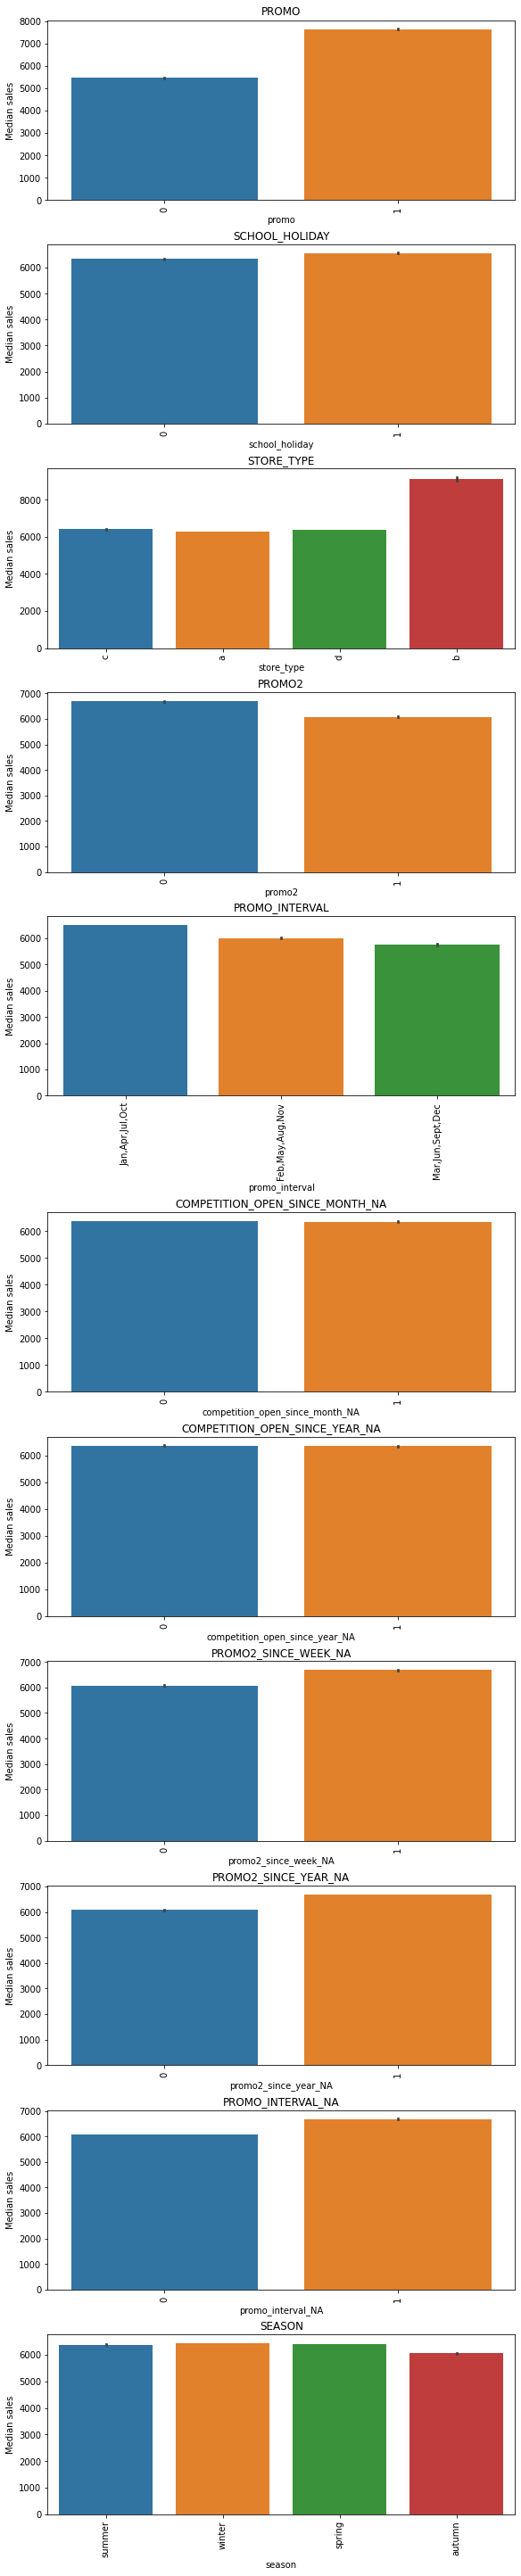

In [87]:
# create a figure object
fig = plt.figure( figsize = (8,40), constrained_layout = True )

# create grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = len(aux_cat_features), figure = fig)

# iterate over each remaining categorical feature 
for index, col in enumerate( aux_cat_features ):
    # plot bar chart
    ax_bar = fig.add_subplot( specs[index, 0] )
    plt.title( col.upper())
    sns.barplot( x = col, y = 'sales', data = df_eda, 
                estimator = np.median, ax = ax_bar )
    plt.title( col.upper() )
    plt.ylabel( 'Median sales' )
    plt.xticks( rotation = 90 );

### Summary

In [88]:
hypothesis_tab = [
['H1', 'TRUE'],
['H2', 'FALSE'],
['H3', 'FALSE'],
['H4', 'FALSE'],
['H5', 'TRUE'],
['H6', 'FALSE'],
['H7', 'TRUE'],
['H8', 'TRUE'],
['H9', 'FALSE'],
['H10', 'FALSE'] 
]

pd.DataFrame( hypothesis_tab, columns = ['HYPOTHESIS', 'CONCLUSION'] )

,HYPOTHESIS,CONCLUSION
0,H1,TRUE
1,H2,FALSE
2,H3,FALSE
3,H4,FALSE
4,H5,TRUE
5,H6,FALSE
6,H7,TRUE
7,H8,TRUE
8,H9,FALSE
9,H10,FALSE


In [89]:
features_tab = [
['assorment', 'low'],
['competition_distance', 'medium'],
['competition_open_since_year', 'low'],
['competition_open_since_month', 'low'],
['promo2_since_week', 'low'],
['promo2_since_year', 'low'],
['week_number', 'low'],    
['year', 'low'],
['month', 'median'],
['day_of_month', 'high'],
['weekday', 'medium'],
['state_holiday', 'medium'],    
]

pd.DataFrame( features_tab, columns = ['FEATURES', 'RELEVANCE INTUITION'] )

,FEATURES,RELEVANCE INTUITION
0,assorment,low
1,competition_distance,medium
2,competition_open_since_year,low
3,competition_open_since_month,low
4,promo2_since_week,low
5,promo2_since_year,low
6,week_number,low
7,year,low
8,month,median
9,day_of_month,high


## Multivariate Analysis

### Numerical Features

In [90]:
# create a list with name of numerical features
bi_num_columns = list( df_num_features.columns )

# once response variable is numeric,
# append response variable to bi_num_columns
bi_num_columns.append('sales')

# create dataframe with all numerical features
multivar_num_analysis = df_eda[ bi_num_columns ]
multivar_num_analysis.head()

,store,customers,competition_distance,day_of_year,sales
0,1,555,1270,212,5263
1,2,625,570,212,6064
2,3,821,14130,212,8314
3,4,1498,620,212,13995
4,5,559,29910,212,4822


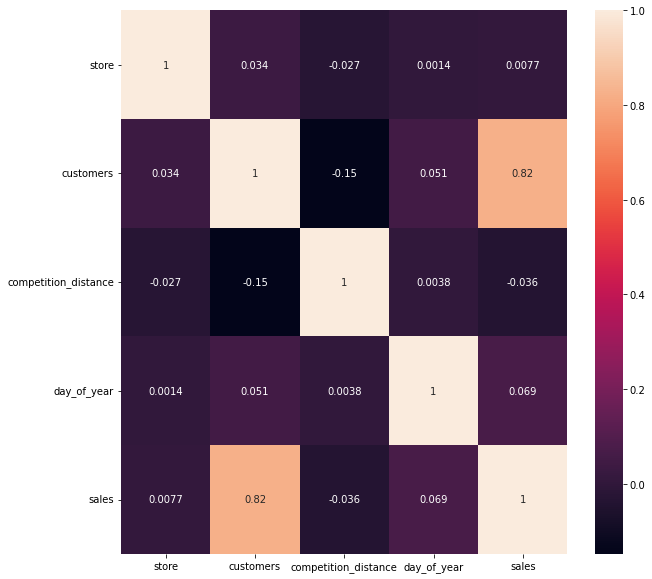

In [91]:
# calculate pearson correlation for numerical features
correlation = multivar_num_analysis.corr( method = 'pearson' )

# create figure and ax object
fig, ax = plt.subplots( figsize = (10, 10) )

# display heatmap of correlation on figure
sns.heatmap( correlation, annot = True, ax = ax)
plt.yticks( rotation = 0 );

### Categorical Features

In [92]:
# create a list with name of categorical features
bi_cat_columns = list(df_cat_features.columns)

# create dataframe with all categorical features
multivar_cat_analysis = df_eda[ bi_cat_columns ]
multivar_cat_analysis.head()

,day_of_week,promo,state_holiday,school_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,day_of_month,month,season,year,week_number,competition_open_since_month_NA,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA
0,5,1,0,1,c,basic,9,2008,0,14,...,31,7,summer,2015,30,0,0,1,1,1
1,5,1,0,1,a,basic,11,2007,1,13,...,31,7,summer,2015,30,0,0,0,0,0
2,5,1,0,1,a,basic,12,2006,1,14,...,31,7,summer,2015,30,0,0,0,0,0
3,5,1,0,1,c,extended,9,2009,0,14,...,31,7,summer,2015,30,0,0,1,1,1
4,5,1,0,1,a,basic,4,2015,0,14,...,31,7,summer,2015,30,0,0,1,1,1


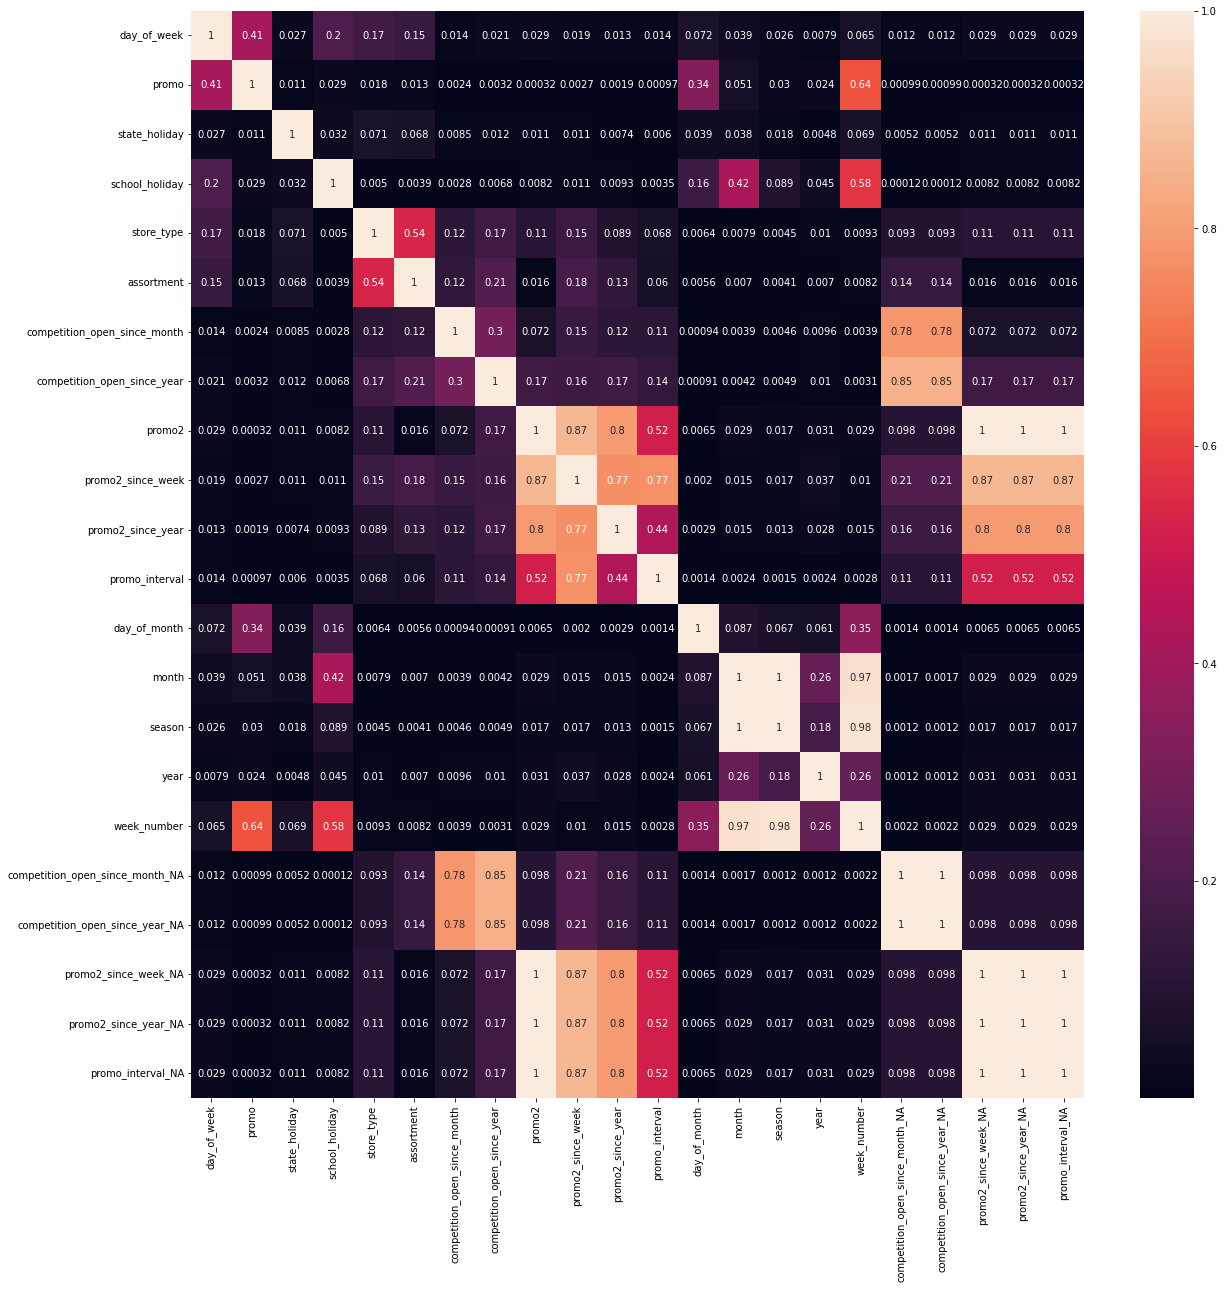

In [93]:
# create a dataframe with cramer-v for every row-column pair
cramer_v_corr = create_cramer_v_dataframe( multivar_cat_analysis )

# create figure and ax object
fig, ax = plt.subplots( figsize = (20, 20) )

# display heatmap of correlation on figure
sns.heatmap( cramer_v_corr, annot = True, ax = ax);

# DATA PREPARATION

## Restore Point

In [94]:
# create a restore point for the previous section dataframe
df_prep = df_eda.copy()

# check dataframe
check_dataframe( df_prep )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0          0.0        1115   
day_of_week                            0          0.0           7   
date                                   0          0.0         942   
sales                                  0          0.0       21734   
customers                              0          0.0        4086   
promo                                  0          0.0           2   
state_holiday                          0          0.0           4   
school_holiday                         0          0.0           2   
store_type                             0          0.0           4   
assortment                             0          0.0           3   
competition_distance                   0          0.0         654   
competition_open_since_month           0          0.0          12   
competition_open_since_year            0          0.0          23   
promo2                            

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,...,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA,day_of_month,day_of_year,month,year,week_number,season
200112,528,1,2015-02-02,15269,1182,1,0,0,a,extended,...,1,0,0,0,2,33,2,2015,5,winter
64502,948,4,2015-06-04,13585,2697,1,a,1,b,extra,...,1,1,1,1,4,155,6,2015,22,summer
176832,663,1,2015-02-23,4680,609,0,0,0,a,extended,...,0,1,1,1,23,54,2,2015,8,winter
742676,872,3,2013-09-04,8491,976,0,0,0,a,extended,...,0,0,0,0,4,247,9,2013,35,autumn
373326,521,4,2014-08-07,6240,494,1,0,1,d,basic,...,0,0,0,0,7,219,8,2014,31,winter


## Remove variables that won't be available in the production environment

In [95]:
# columns not available in production environment
cols_to_remove = ['customers', 'state_holiday', 'school_holiday', 'promo']

In [96]:
# drop columns to be removed
df_prep.drop( columns = cols_to_remove, axis = 'columns', inplace = True )

# check column names
[ print( column ) for column in df_prep.columns ];

store
day_of_week
date
sales
store_type
assortment
competition_distance
competition_open_since_month
competition_open_since_year
promo2
promo2_since_week
promo2_since_year
promo_interval
competition_open_since_month_NA
competition_open_since_year_NA
promo2_since_week_NA
promo2_since_year_NA
promo_interval_NA
day_of_month
day_of_year
month
year
week_number
season


## Revert fillNA

In [97]:
# revert fillNA to avoid information leakage once 
# missing value inputation was made considering 
# all data in the dataset (to calculate most frequent category and
# median) and, consequently, considered data that 
# would be available only in the test dataset

# Once competition_distance had just 0.3% of missing values,
# there is no need to reverse inputation for such small %

# create a list with feature to reverse missing values
list_reverse_missing = [
'competition_open_since_month',
'competition_open_since_year', 
'promo2_since_week', 
'promo2_since_year', 
'promo_interval'
]

# iterate over list and reverse inputation
for feature in list_reverse_missing:
     df_prep[feature] = reverse_inputation(df_prep, feature,
                             f'{feature}_NA', 
                             reverse_inputter = np.nan, only_col_return = True)

In [98]:
check_dataframe( df_prep )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0     0.000000        1115   
day_of_week                            0     0.000000           7   
date                                   0     0.000000         942   
sales                                  0     0.000000       21734   
store_type                             0     0.000000           4   
assortment                             0     0.000000           3   
competition_distance                   0     0.000000         654   
competition_open_since_month      268619     0.318121          12   
competition_open_since_year       268619     0.318121          23   
promo2                                 0     0.000000           2   
promo2_since_week                 423307     0.501316          24   
promo2_since_year                 423307     0.501316           7   
promo_interval                    423307     0.501316           3   
competition_open_since_month_NA   

,store,day_of_week,date,sales,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,...,competition_open_since_year_NA,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA,day_of_month,day_of_year,month,year,week_number,season
516574,1115,3,2014-03-26,4481,d,extended,5350,NaN,NaN,1,...,1,0,0,0,26,85,3,2014,12,spring
661817,293,5,2013-11-15,4766,c,extended,140,11.0,2007.0,0,...,0,1,1,1,15,319,11,2013,45,winter
841673,634,5,2013-06-07,6480,d,basic,18610,NaN,NaN,0,...,1,1,1,1,7,158,6,2013,22,summer
402337,553,1,2014-07-07,5658,c,basic,3040,9.0,2002.0,1,...,0,0,0,0,7,188,7,2014,27,summer
545115,666,5,2014-02-28,6643,c,extended,2700,NaN,NaN,1,...,1,0,0,0,28,59,2,2014,8,winter


## Split dataframe into training and test dataset

In [99]:
# calculate most recent date
most_recent_date = df_prep['date'].max()

# calculte six weeks before most recent date
six_weeks_before_date = df_prep['date'].max() - datetime.timedelta( weeks = 6 )

# calculte twelve weeks before most recent date
twelve_weeks_before_date = df_prep['date'].max() - datetime.timedelta( weeks = 12 )

# print dates information
print( f'Most recent date: {most_recent_date.date()}.' )
print( f'Six weeks before most recent date: {six_weeks_before_date.date()}.' )
print( f'Twelve weeks before most recent date: {twelve_weeks_before_date.date()}.')

# check data interval operations
# 6 weeks = 42 days
assert( (most_recent_date - six_weeks_before_date) == datetime.timedelta(days = 42) )
# 12 weeks = 84 days
assert( (most_recent_date - twelve_weeks_before_date) == datetime.timedelta(days = 84) )

Most recent date: 2015-07-31.
Six weeks before most recent date: 2015-06-19.
Twelve weeks before most recent date: 2015-05-08.


In [100]:
# test dataset = last six weeks
df_test = df_prep[ df_prep['date'] >= six_weeks_before_date ]

# validation dataset = last six weeks before test dataset
df_validation = df_prep[ (df_prep['date'] >= twelve_weeks_before_date) & 
                         (df_prep['date'] < six_weeks_before_date) ]

# train dataset = before last twelve weeks
df_train = df_prep[ df_prep['date'] < twelve_weeks_before_date ]

# check splits
assert len( df_prep ) == len( df_train ) + len( df_validation ) + len( df_test )

# check proportion of dataframes sizes after splits
print( f'Proportion test / original: {round( len(df_test) / len(df_prep) * 100, 1)}%' )
print( f'Proportion validation / original: {round( len(df_validation) / len(df_prep) * 100, 1)}%' )
print( f'Proportion train / original: {round( len(df_train) / len(df_prep) * 100, 1)}%' )

Proportion test / original: 4.9%
Proportion validation / original: 4.4%
Proportion train / original: 90.7%


In [101]:
# split train dataset into x and y
y_train = df_train[ 'sales' ]
X_train = df_train.drop( 'sales', axis = 1 )

# split validation dataset into x and y
y_validation = df_validation[ 'sales' ]
X_validation = df_validation.drop( 'sales', axis = 1 )

# split test dataset into x and y
y_test = df_test[ 'sales' ]
X_test = df_test.drop( 'sales', axis = 1 )

In [102]:
print( 'Training Min Date: {}'.format( X_train['date'].min().date() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max().date() ) )

print( 'Validation Min Date: {}'.format( X_validation['date'].min().date() ) )
print( 'Validation Max Date: {}'.format( X_validation['date'].max().date() ) )

print( 'Test Min Date: {}'.format( X_test['date'].min().date() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max().date() ) )

Training Min Date: 2013-01-01
Training Max Date: 2015-05-07
Validation Min Date: 2015-05-08
Validation Max Date: 2015-06-18
Test Min Date: 2015-06-19
Test Max Date: 2015-07-31


## Missing value inputation on training dataset

In [103]:
####################
# NOTE: any transformation will be made via engineer_features function !!!


# # categorical features -> most frequent
# most_frequent_inputter = SimpleImputer( missing_values = np.nan, strategy = 'most_frequent' )

# # fill competition_open_since_month column
# na_inputter( X_train, 'competition_open_since_month', 
#             most_frequent_inputter, transform = True, save_inputter = True)

# # fill competition_open_since_year column
# na_inputter( X_train, 'competition_open_since_year', 
#             most_frequent_inputter,  transform = True, save_inputter = True)

# # fill promo2_since_week column
# na_inputter( X_train, 'promo2_since_week', 
#             most_frequent_inputter,  transform = True, save_inputter = True)

# # fill promo2_since_year column
# na_inputter( X_train, 'promo2_since_year', 
#             most_frequent_inputter,  transform = True, save_inputter = True)

# # fill promo_interval column
# na_inputter( X_train, 'promo_interval', 
#             most_frequent_inputter,  transform = True, save_inputter = True);

## Normalization

## Rescaling

In [104]:
####################
# NOTE: any transformation will be made via engineer_features function !!!


# create robust scaler and min-max objects
# mms = MinMaxScaler()

### Rescale with Min-Max Scaler (due to no outliers)

In [105]:
####################
# NOTE: any transformation will be made via engineer_features function !!!


# list_cols_no_outlier = [
#     'store', 
#     'competition_open_since_month',
#     'promo2_since_week', 
#     'promo2_since_year', 
#     'year', 
# ]

# for col_no_outlier in list_cols_no_outlier:
#     # make min-max scaler learn col_no_outlier of training dataset
#     # and save scaler
#     with open(f'../src/features/{col_no_outlier}_scaler.pkl', 'wb') as file: 
#         mms.fit( X_train[ col_no_outlier ].values.reshape(-1,1) )
#         pickle.dump( mms, file)

#     # load min-max scaler 
#     with open(f'../src/features/{col_no_outlier}_scaler.pkl', 'rb') as file: 
#         mms = pickle.load( file )
#     # transform col_outlier
#     X_train[ col_no_outlier ] = mms.transform( X_train[ col_no_outlier ].values.reshape(-1,1) )

## Discretization

In [106]:
####################
# NOTE: any transformation will be made via engineer_features function !!!


# # create bins
# competition_open_since_year_bins = [1989, 1990, 1995, 2000, 2005, 2008, 2010, 2012, 2014, 2016]
# competition_distance_bins = [0, 50, 100, 500, 1000, 5000, 15000, 100000]

# # create dictionary with feateres and their bins
# dict_bins = {'competition_open_since_year': competition_open_since_year_bins,
#              'competition_distance': competition_distance_bins
#             }

# # iteration over feartures and bins
# for col, bin in dict_bins.items():
#     # discretize column
#     X_train[ col ] = pd.cut( X_train[ col ], bins = bin )
#     # convert categoric dtype to integer
#     X_train[ col ] = pd.Categorical( X_train[ col ] ).codes
#     # make category labels range from 0 to 2
#     X_train[ col ] = X_train[ col ] / ( ( len(bin) - 2 ) / 2 )

## Encoding

In [107]:
####################
# NOTE: any transformation will be made via engineer_features function !!!


# create a list with categorical features
list_col_cat = [
    'store_type', 
    'assortment', 
    'promo2', 
    'promo_interval',
    'competition_open_since_month_NA', 
    'competition_open_since_year_NA',
    'promo2_since_week_NA', 
    'promo2_since_year_NA', 
    'promo_interval_NA',
]

# print unique values for each feature
for col in list_col_cat:
    print( col, '--->', df_prep[col].unique())

store_type ---> ['c' 'a' 'd' 'b']
assortment ---> ['basic' 'extended' 'extra']
promo2 ---> [0 1]
promo_interval ---> [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
competition_open_since_month_NA ---> [0 1]
competition_open_since_year_NA ---> [0 1]
promo2_since_week_NA ---> [1 0]
promo2_since_year_NA ---> [1 0]
promo_interval_NA ---> [1 0]


In [108]:
###################
# NOTE: any transformation will be made via engineer_features function !!!

# list with feature to apply order encoding
ordinal_encoder_list = [
    'store_type', 
    'assortment', 
    'promo_interval'
]


# auxiliary list
aux_dict = {}

# iterate over features
for feature in ordinal_encoder_list:
    # create a copy of feature values from X_train
    df_aux = pd.DataFrame( X_train[ feature ] )
    # append sales column
    df_aux[ 'sales' ] = y_train
    
    # group by feature and aggregate on median sales
    df_aux = df_aux[ [ feature, 'sales' ] ].groupby( feature ).median().reset_index()
    # sort dataframe according to median sales
    df_aux = df_aux.sort_values('sales')
    
    # create a dict with feature ordered by median sales
    # key: feature value; value: respective order
    aux_dict[ feature ] = { item: index for index, item in enumerate( df_aux[ feature ] ) } 

# check auxiliary dict
aux_dict

{'store_type': {'a': 0, 'd': 1, 'c': 2, 'b': 3},
 'assortment': {'basic': 0, 'extended': 1, 'extra': 2},
 'promo_interval': {'Mar,Jun,Sept,Dec': 0,
  'Feb,May,Aug,Nov': 1,
  'Jan,Apr,Jul,Oct': 2}}

## Response Variable Transformation

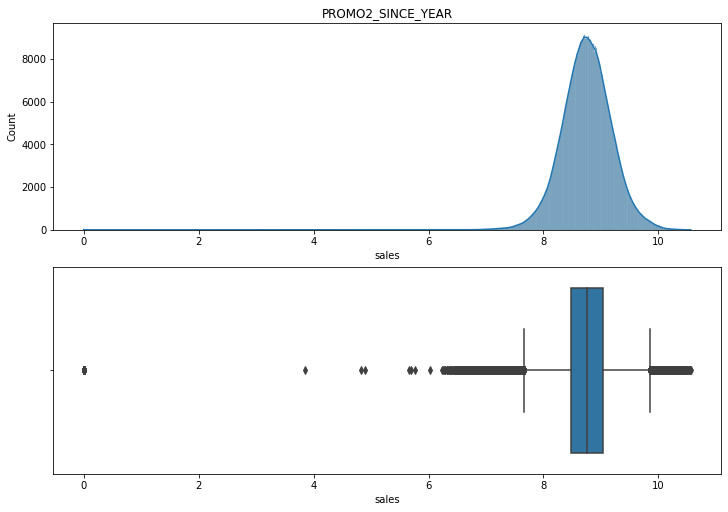

In [109]:
###################
# NOTE: any transformation will be made via engineer_features function !!!


# apply log transformation
y_train = np.log1p( y_train ) 

# create a figure object
fig = plt.figure( figsize = (10, 7), constrained_layout = True );

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig);

# check sales distribution
hist_axs = fig.add_subplot( specs[ 0, 0 ] )
box_axs = fig.add_subplot( specs[ 1, 0 ] )

# set title
hist_axs.set_title( column.upper() )
# plot histogram
sns.histplot( x = y_train, ax = hist_axs, kde = True )
# plot boxplot
sns.boxplot(  x = y_train, ax = box_axs );

## Nature Transformation

In [110]:
####################
# NOTE: any transformation will be made via engineer_features function !!!


# # create season dictionary for mapping
# season_map = {
# 'winter': 0, 
# 'spring': 1, 
# 'autumn': 2, 
# 'summer': 3
# }

# # map season feature
# X_train['season'] = X_train['season'].map( season_map )

# # create dict with feature and its cycle
# cyclic_dict = {
#     'season': 4,
#     'day_of_month': 30,
#     'day_of_year': 365,
#     'month': 12,
#     'week_number': 52,
#     'day_of_week': 7
# }

# # iterate over features
# for col, cycle in cyclic_dict.items():
#     # apply sin and cos transformation on features    
#     X_train[ f'{col}_sin' ] = X_train[ col ].apply( lambda x: np.sin( x * ( 2. * np.pi/ cycle ) ) )
#     X_train[ f'{col}_cos' ] = X_train[ col ].apply( lambda x: np.cos( x * ( 2. * np.pi/ cycle ) ) )
#     # remove cyclic column from dataframe
#     X_train.drop( columns = [ col ], axis = 'columns', inplace = True )

## Transformations

In [111]:
# Apply all feature transformation on the previous steps
# via engineer_features function
help( engineer_features )

Help on function engineer_features in module __main__:

engineer_features(X_dataframe, X_columns)
    Apply the same chosen feature transformations that were fit on
    the X_train.
    
    Args:
        X_dataframe: X_train or X_validation or X_test dataframe to apply
            feature engineering according to choosen feature transformations
            that were fit on the X_train.
        X_columns: columns of X_train or X_validation or X_test dataframe 
            to apply feature engineering according to choosen feature 
            transformations that were fit on the X_train.
    
    Return:
        X_dataframe: return the X_dataframe transformed.



In [112]:
# transform X_train
X_train = engineer_features( X_train, X_train.columns )

## Final check

In [113]:
# check dataframe
check_dataframe( X_train )

                                 Num NAs  Percent NAs  Num unique  \
store                                  0          0.0        1115   
date                                   0          0.0         857   
store_type                             0          0.0           4   
assortment                             0          0.0           3   
competition_distance                   0          0.0           7   
competition_open_since_month           0          0.0          12   
competition_open_since_year            0          0.0          10   
promo2                                 0          0.0           2   
promo2_since_week                      0          0.0          24   
promo2_since_year                      0          0.0           7   
promo_interval                         0          0.0           3   
competition_open_since_month_NA        0          0.0           2   
competition_open_since_year_NA         0          0.0           2   
promo2_since_week_NA              

,store,date,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,month_sin,month_cos,week_number_sin,week_number_cos,season_sin,season_cos
343785,0.874327,2014-09-08,0,1,1.666667,0.727273,1.75,1,0.265306,0.333333,...,0.994522,-0.104528,-0.924291,-0.381689,-1.000000,-1.836970e-16,-9.350162e-01,-0.354605,1.224647e-16,-1.000000e+00
736986,0.678636,2013-09-09,0,1,1.333333,0.727273,1.75,0,0.265306,0.333333,...,0.951057,-0.309017,-0.930724,-0.365723,-1.000000,-1.836970e-16,-9.350162e-01,-0.354605,1.224647e-16,-1.000000e+00
125553,0.604129,2015-04-10,0,0,1.333333,1.000000,0.75,1,0.612245,0.666667,...,0.866025,-0.500000,0.988678,-0.150055,0.866025,-5.000000e-01,9.927089e-01,-0.120537,1.000000e+00,6.123234e-17
591928,0.581688,2014-01-17,0,0,1.666667,0.909091,0.75,0,0.265306,0.333333,...,-0.406737,-0.913545,0.288482,0.957485,0.500000,8.660254e-01,2.393157e-01,0.970942,0.000000e+00,1.000000e+00
812577,0.473070,2013-07-03,0,1,2.000000,0.727273,1.75,1,0.734694,0.000000,...,0.587785,0.809017,-0.025818,-0.999667,-0.500000,-8.660254e-01,1.224647e-16,-1.000000,-1.000000e+00,-1.836970e-16


In [114]:
# check numerical statistics
numerical_statistics( X_train.drop(columns = 'date', axis = 'columns') )

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,store,0.500406,5.000000e-01,0.288808,0.000000,1.000000,1.000000,0.000356,-1.198937
1,store_type,0.629268,0.000000e+00,0.782203,0.000000,3.000000,3.000000,0.984915,0.061695
2,assortment,0.483126,0.000000e+00,0.518817,0.000000,2.000000,2.000000,0.276378,-1.436438
3,competition_distance,1.290964,1.333333e+00,0.451115,0.000000,2.000000,2.000000,-0.500546,-0.066389
4,competition_open_since_month,0.617226,7.272727e-01,0.252427,0.000000,1.000000,1.000000,-0.716285,-0.480123
5,competition_open_since_year,1.411045,1.500000e+00,0.423921,-0.250000,2.000000,2.250000,-0.806572,-0.277076
6,promo2,0.497572,0.000000e+00,0.499994,0.000000,1.000000,1.000000,0.009711,-1.999911
7,promo2_since_week,0.358939,2.653061e-01,0.223684,0.000000,1.000000,1.000000,1.160275,0.332768
8,promo2_since_year,0.395754,3.333333e-01,0.204987,0.000000,1.000000,1.000000,0.686361,0.582384
9,promo_interval,1.692645,2.000000e+00,0.635702,0.000000,2.000000,2.000000,-1.866059,2.012653


# FEATURE SELECTION

In [115]:
# # prepare x_train for buruta
# X_train_model = X_train.drop('date', axis = 'columns').values

# # prepare y_train for buruta
# y_train_model = y_train.values

# # create random forest classifier object
# rf = RandomForestRegressor( n_jobs = -1 )

# # run boruta to select besst features
# boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, 
#                    random_state = 10 ).fit( X_train_model, y_train_model)

In [116]:
# #columns selected by Boruta 
# cols_selected_bool = boruta.support_.tolist()

# #columns selected by boruta
# cols_selected_boruta_list = X_train.drop('date', axis = 'columns').loc[ :, cols_selected_bool ].columns.to_list()

# cols_selected_boruta_list

In [117]:
cols_selected_boruta_list = [
    'store',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2_since_week',
    'promo2_since_year',
    'day_of_month_sin',
    'day_of_month_cos',
    'day_of_year_sin',
    'day_of_year_cos',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos'
]

In [118]:
# create a copy of boruta selection
cols_selected = cols_selected_boruta_list

# MACHINE LEARNING MODELLING

In [119]:
####### prepare training datasets
# prepare x_train for ML models
X_train_model = X_train[ cols_selected ].values

# prepare y_train ML models
y_train_model = y_train.values

## Base Model

In [120]:
# # instanciate model
# mean_base_model = DummyRegressor( strategy = "mean" )

# # fit model to training data
# mean_base_model.fit( X_train_model, y_train_model )

# # Save the trained model
# with open( '../models/mean_base_model.pkl', 'wb') as file:
#     pickle.dump( mean_base_model, file)

# Load the trained model back from file
with open( '../models/mean_base_model.pkl', 'rb') as file:  
    mean_base_model = pickle.load( file )

# calculate training pemean_base_modelormance with cross-validation
mean_base_model_result_cv = time_series_cross_validation( X_train_model, y_train_model, 
                                             kfold = 5, model_name = 'Mean Base Regression', 
                                             model = mean_base_model, verbose = False )

mean_base_model_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,MPE CV
0,Mean Base Regression,2360.32 +/- 417.8,0.41 +/- 0.08,3317.74 +/- 598.03,-0.1 +/- 0.11


## Multiple Linear Regression

In [121]:
# # instanciate model
# lr = LinearRegression( n_jobs = -1 )

# # fit model to training data
# lr.fit( X_train_model, y_train_model )

# # Save the trained model
# with open( '../models/lr.pkl', 'wb') as file:
#     pickle.dump( lr, file)

# Load the trained model back from file
with open( '../models/lr.pkl', 'rb') as file:  
    lr = pickle.load( file )

# calculate training performance with cross-validation
lr_result_cv = time_series_cross_validation( X_train_model, y_train_model, 
                                             kfold = 5, model_name = 'Linear Regression', 
                                             model = lr, verbose = False )

lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,MPE CV
0,Linear Regression,2289.22 +/- 410.29,0.39 +/- 0.07,3209.41 +/- 595.52,-0.09 +/- 0.11


## Lasso Regression

In [122]:
# # instanciate model
# lasso = Lasso( random_state = 10 )

# # fit model to training data
# lasso.fit( X_train_model, y_train_model )

# # Save the trained model
# with open( '../models/lasso.pkl', 'wb') as file:
#     pickle.dump( lasso, file)

# Load the trained model back from file
with open( '../models/lasso.pkl', 'rb') as file:  
    lasso = pickle.load( file )

# calculate training performance with cross-validation
lasso_result_cv = time_series_cross_validation( X_train_model, y_train_model, 
                                             kfold = 5, model_name = 'Lasso Regression', 
                                             model = lasso, verbose = False )

lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,MPE CV
0,Lasso Regression,2360.32 +/- 417.8,0.41 +/- 0.08,3317.74 +/- 598.03,-0.1 +/- 0.11


## KNN Regression

In [123]:
# # instanciate model
# knn = KNeighborsRegressor( n_jobs = -1 )

# # fit model to training data
# knn.fit( X_train_model, y_train_model )

# # Save the trained model
# with open( '../models/knn.pkl', 'wb') as file:
#     pickle.dump( knn, file)

# Load the trained model back from file
with open( '../models/knn.pkl', 'rb') as file:  
    knn = pickle.load( file )

# calculate training performance with cross-validation
knn_result_cv = time_series_cross_validation( X_train_model, y_train_model, 
                                             kfold = 5, model_name = 'KNN Regression', 
                                             model = knn, verbose = False )

knn_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,MPE CV
0,KNN Regression,1877.97 +/- 304.61,0.34 +/- 0.1,2605.54 +/- 401.93,-0.1 +/- 0.09


## LightGBM 

In [124]:
# # instanciate model
# lgbm = LGBMRegressor( random_state = 10, n_jobs = -1)

# # fit model to training data
# lgbm.fit( X_train_model, y_train_model )

# # Save the trained model
# with open( '../models/lgbm.pkl', 'wb') as file:
#     pickle.dump( lgbm, file)

# Load the trained model back from file
with open( '../models/lgbm.pkl', 'rb') as file:  
    lgbm = pickle.load( file )

# calculate training pelgbmormance with cross-validation
lgbm_result_cv = time_series_cross_validation( X_train_model, y_train_model, 
                                             kfold = 5, model_name = 'LightGBM Regression', 
                                             model = lgbm, verbose = False )

lgbm_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,MPE CV
0,LightGBM Regression,1603.02 +/- 192.63,0.3 +/- 0.09,2232.88 +/- 257.35,-0.07 +/- 0.08


## Models comparison

In [125]:
# concatenate results
modelling_result = pd.concat( [mean_base_model_result_cv,
                               lr_result_cv,
                               lasso_result_cv,
                               knn_result_cv,
                               lgbm_result_cv                               
                              ] )

# order results by RMSE
modelling_result.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV,MPE CV
0,LightGBM Regression,1603.02 +/- 192.63,0.3 +/- 0.09,2232.88 +/- 257.35,-0.07 +/- 0.08
0,KNN Regression,1877.97 +/- 304.61,0.34 +/- 0.1,2605.54 +/- 401.93,-0.1 +/- 0.09
0,Linear Regression,2289.22 +/- 410.29,0.39 +/- 0.07,3209.41 +/- 595.52,-0.09 +/- 0.11
0,Mean Base Regression,2360.32 +/- 417.8,0.41 +/- 0.08,3317.74 +/- 598.03,-0.1 +/- 0.11
0,Lasso Regression,2360.32 +/- 417.8,0.41 +/- 0.08,3317.74 +/- 598.03,-0.1 +/- 0.11


Chosen model: **LightGBM**

# HYPERPARAMETER FINE TUNING

**RANDOM SEARCH** method was used to tune hyperparameters

In [126]:
# # define params search scope
# params_search = {
#     'num_leaves': [7, 21, 70],
#     'min_child_samples': [100, 300, 1000],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.1, 0.3, 0.9],
#     'n_estimators': [30, 100, 300]
# }

# # number of iterations
# MAX_EVAL = 20

# # create best params dataframe
# df_params_performance = pd.DataFrame()

# # perform RANDOM SEARCH to find best params
# for i in range(MAX_EVAL):
#     # display iteration number
#     print( f'At {i+1}/{MAX_EVAL} iteration')
    
#     if i == 0:
#         # set chosen params as default
#         chosen_params = { key: 'default' for key, value in params_search.items() }
        
#         # model definition with default params
#         lgbm = LGBMRegressor( random_state = 10, n_jobs = -1)

#     else:
#         # randomly choose params
#         chosen_params = { key: random.choice(value) for key, value in params_search.items() }

#         # define model with random params
#         lgbm = LGBMRegressor(num_leaves = chosen_params['num_leaves'],
#                              min_child_samples = chosen_params['min_child_samples'],
#                              max_depth = chosen_params['max_depth'],
#                              learning_rate = chosen_params['learning_rate'],
#                              n_estimators = chosen_params['n_estimators'],
#                              n_jobs = -1,
#                              random_state = 10
#                             )  
        
#     # evalute model with cross-validation
#     cv_report = time_series_cross_validation( X_train_model, 
#                                               y_train_model, 
#                                               kfold = 5, 
#                                               model_name = f'{chosen_params}', 
#                                               model = lgbm
#                                             )        

#     # append row to dataframe
#     df_params_performance = df_params_performance.append( cv_report )


# # display params performance
# pd.set_option('display.max_colwidth', None)
# df_params_performance.sort_values( ['RMSE CV'] )

In [127]:
best_params = {
    'num_leaves': 70, 
    'min_child_samples': 1000, 
    'max_depth': 6, 
    'learning_rate': 0.3, 
    'n_estimators': 300
}

# PERFORMANCE EVALUATION AND INTERPRETATION

## Training Performance

In [128]:
# instanciate model
tuned_lgbm = LGBMRegressor( num_leaves = 70, 
                            min_child_samples = 1000, 
                            max_depth = 6, 
                            learning_rate = 0.3, 
                            n_estimators = 300,
                            n_jobs = -1,
                            random_state = 10
                          )

# fit model to training data
tuned_lgbm.fit( X_train_model, y_train_model )

# calculate training performance with cross-validation
tuned_lgbm_result_cv = time_series_cross_validation( X_train_model, y_train_model, 
                                                     kfold = 5, 
                                                     model_name = 'Tuned LightGBoost Regression', 
                                                     model = tuned_lgbm, verbose = False )
# display cv results
tuned_lgbm_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,MPE CV
0,Tuned LightGBoost Regression,1269.02 +/- 246.53,0.26 +/- 0.11,1738.3 +/- 279.15,-0.07 +/- 0.09


In [129]:
training_performance = {
 'Model Name': {0: 'Tuned LightGBoost Regression'},
 'MAE CV': {0: '1269.02 +/- 246.53'},
 'MAPE CV': {0: '0.26 +/- 0.11'},
 'RMSE CV': {0: '1738.3 +/- 279.15'},
 'MPE CV': {0: '-0.07 +/- 0.09'}
}

## Generalization Performance

### Generalization Performance metrics

In [130]:
# ####### prepare validation datasets
# # apply transformations for X_validation dataframe
# X_validation = engineer_features( X_validation, X_validation.columns )

# # prepare X_validation for ML models
# X_validation_model = X_validation[ cols_selected ].values

# # apply log transformation on y_validation
# y_validation = np.log1p( y_validation ) 

# # prepare y_validation for ML models
# y_validation_model = y_validation.values

In [131]:
# # make predictions with model
# yhat = tuned_lgbm.predict( X_validation_model )        

In [132]:
# # calculate performance
# # np.where is used to avoid 'division by zero' error
# # in case of sales = zero.
# learning_performance = ml_error( 'Learning Performance', 
#                                  np.where( np.expm1( y_validation_model ) == 0, 1, np.expm1( y_validation_model ) ), 
#                                  np.where( np.expm1( yhat ) == 0              , 1, np.expm1( yhat )               )
#                                )

# learning_performance

In [133]:
training_performance = {
 'Model Name': {0: 'Tuned LightGBoost Regression'},
 'MAE CV': {0: '1269.02 +/- 246.53'},
 'MAPE CV': {0: '0.26 +/- 0.11'},
 'RMSE CV': {0: '1738.3 +/- 279.15'},
 'MPE CV': {0: '-0.07 +/- 0.09'}
}

learning_performance = {
 'Model Name': {0: 'Learning Performance'},
 'MAE': {0: 1113.500589095296},
 'MAPE': {0: 0.3227052531532383},
 'RMSE': {0: 1560.8072405953012},
 'MPE': {0: -0.13084998173961135}
};

### Final Model

In [134]:
# # concatenate X_train_model with X_validation_model to train final model
# X_train_plus_val_model = np.concatenate( (X_train_model, X_validation_model), axis = 0)

# # concatenate y_train_model with y_validation_model to train final model
# y_train_plus_val_model = np.concatenate( (y_train_model, y_validation_model), axis = 0)

In [135]:
# # train final model on train + validation data
# tuned_lgbm.fit( X_train_plus_val_model, y_train_plus_val_model )

In [136]:
# # Save the xgb trained model
# with open( '../src/models/model_rossmann_sales.pkl', 'wb' ) as file:
#     pickle.dump( tuned_lgbm, file )

In [137]:
# Load the model back from file
with open( '../src/models/model_rossmann_sales.pkl', 'rb') as file:  
    model_rossmann_sales = pickle.load( file )

## Business Performance

In [138]:
# create auxiliary dataframe
df_aux_generalization = X_test.copy()
# append sales column to auxiliary dataframe
df_aux_generalization[ 'real_sales' ] = y_test

# check auxiliary dataframe
print( df_aux_generalization.shape )
df_aux_generalization.head()

(41396, 24)


,store,day_of_week,date,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,promo2_since_week_NA,promo2_since_year_NA,promo_interval_NA,day_of_month,day_of_year,month,year,week_number,season,real_sales
0,1,5,2015-07-31,c,basic,1270,9.0,2008.0,0,NaN,...,1,1,1,31,212,7,2015,30,summer,5263
1,2,5,2015-07-31,a,basic,570,11.0,2007.0,1,13.0,...,0,0,0,31,212,7,2015,30,summer,6064
2,3,5,2015-07-31,a,basic,14130,12.0,2006.0,1,14.0,...,0,0,0,31,212,7,2015,30,summer,8314
3,4,5,2015-07-31,c,extended,620,9.0,2009.0,0,NaN,...,1,1,1,31,212,7,2015,30,summer,13995
4,5,5,2015-07-31,a,basic,29910,4.0,2015.0,0,NaN,...,1,1,1,31,212,7,2015,30,summer,4822


In [139]:
####### prepare test datasets
# apply transformations for X_test dataframe
X_test = engineer_features( X_test, X_test.columns )

# prepare X_test for ML models
X_test_model = X_test[ cols_selected ].values

# apply log transformation on y_test
y_test = np.log1p( y_test ) 

# prepare y_test for ML models
y_test_model = y_test.values

In [140]:
# make predictions with model
yhat = model_rossmann_sales.predict( X_test_model )

In [141]:
# append predictions to auxiliary dataframe
df_aux_generalization[ 'predict_sales' ] = np.expm1( yhat )
df_aux_generalization[ 'predict_sales' ] = df_aux_generalization[ 'predict_sales' ].astype( int )
df_aux_generalization.head()

,store,day_of_week,date,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,promo2_since_year_NA,promo_interval_NA,day_of_month,day_of_year,month,year,week_number,season,real_sales,predict_sales
0,1,5,2015-07-31,c,basic,1270,9.0,2008.0,0,NaN,...,1,1,31,212,7,2015,30,summer,5263,6027
1,2,5,2015-07-31,a,basic,570,11.0,2007.0,1,13.0,...,0,0,31,212,7,2015,30,summer,6064,6245
2,3,5,2015-07-31,a,basic,14130,12.0,2006.0,1,14.0,...,0,0,31,212,7,2015,30,summer,8314,9085
3,4,5,2015-07-31,c,extended,620,9.0,2009.0,0,NaN,...,1,1,31,212,7,2015,30,summer,13995,12220
4,5,5,2015-07-31,a,basic,29910,4.0,2015.0,0,NaN,...,1,1,31,212,7,2015,30,summer,4822,6601


In [142]:
# calculate sales prediction for each store in the last 6 weeks
stores_prediction = df_aux_generalization[['store', 'predict_sales']].groupby('store').sum().reset_index()
stores_prediction

,store,predict_sales
0,1,167228
1,2,177391
2,3,247071
3,4,333650
4,5,172730
...,...,...
1110,1111,186922
1111,1112,345896
1112,1113,246889
1113,1114,711935


### Error Analysis per Store

In [143]:
# change scientific notation of pandas
pd.options.display.float_format = '{:.3f}'.format

# calculate sales prediction for each store in the last 6 weeks
store_prediction = df_aux_generalization[['store', 'predict_sales']].groupby('store').sum().reset_index()
# calculate MAE for each store in the last 6 weeks
store_mae = df_aux_generalization[['store', 'real_sales', 'predict_sales']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['real_sales'], x['predict_sales'] ) ).reset_index().rename( columns={0:'MAE'})
# calculate MAPE for each store in the last 6 weeks
store_mape = df_aux_generalization[['store', 'real_sales', 'predict_sales']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['real_sales'], x['predict_sales'] ) ).reset_index().rename( columns={0:'MAPE'})
# calculate MPE for each store in the last 6 weeks
store_mpe = df_aux_generalization[['store', 'real_sales', 'predict_sales']].groupby( 'store' ).apply( lambda x: mean_percentage_error( x['real_sales'], x['predict_sales'] ) ).reset_index().rename( columns={0:'MPE'})  

# merge dataframes
final_report = pd.merge( store_prediction, store_mae, how='inner', on='store' )
final_report = pd.merge( final_report, store_mape, how='inner', on='store' )
final_report = pd.merge( final_report, store_mpe, how='inner', on='store' )

# create best scenario and worst scenario of predictins
final_report['worst_scenario'] = final_report['predict_sales'] - final_report['MAE']
final_report['best_scenario']  = final_report['predict_sales'] + final_report['MAE']
final_report = final_report[ ['store', 'predict_sales', 'worst_scenario', 
                              'best_scenario', 'MAE', 'MAPE', 'MPE'] 
                           ]
final_report.sample(10)

,store,predict_sales,worst_scenario,best_scenario,MAE,MAPE,MPE
653,654,219842,218603.568,221080.432,1238.432,0.218,0.025
338,339,172318,171531.189,173104.811,786.811,0.143,0.115
993,994,157094,156175.162,158012.838,918.838,0.169,0.045
356,357,287888,287224.243,288551.757,663.757,0.082,0.026
815,816,186608,186043.027,187172.973,564.973,0.133,-0.107
836,837,119889,119140.378,120637.622,748.622,0.181,0.181
576,577,176397,175894.027,176899.973,502.973,0.103,0.022
376,377,273848,272737.865,274958.135,1110.135,0.124,0.104
823,824,247829,247014.297,248643.703,814.703,0.120,0.103
564,565,234785,234259.784,235310.216,525.216,0.080,0.003


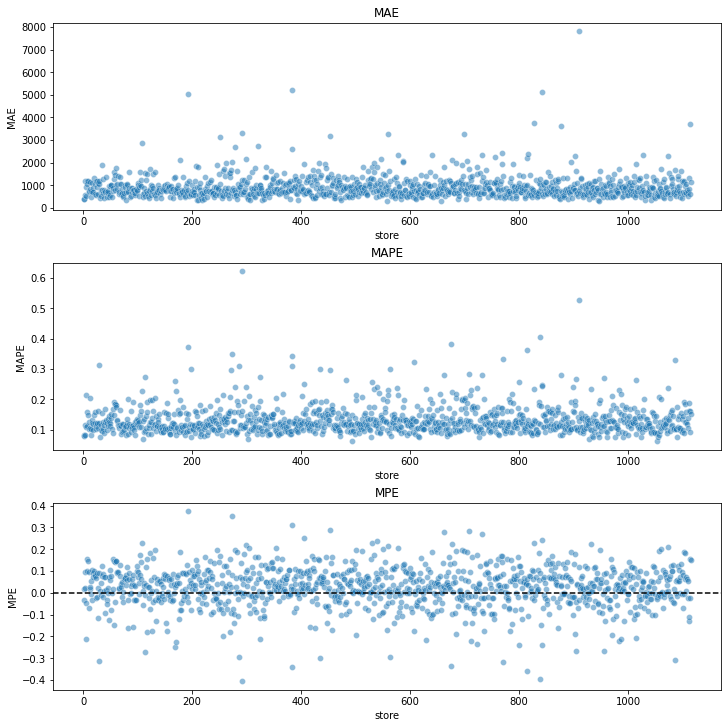

In [144]:
# create a figure object
fig = plt.figure( figsize = (10, 10) , constrained_layout = True )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 3, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] ) # first row, first column
ax2 = fig.add_subplot( specs[ 1, 0 ] ) # second row, first column
ax3 = fig.add_subplot( specs[ 2, 0 ] ) # third row, first column

# plot MAE
sns.scatterplot( data = final_report, x = 'store', y = 'MAE',
                 ax = ax1, alpha = 0.5)
ax1.set_title( 'MAE' )

# plot MAPE
sns.scatterplot( data = final_report, x = 'store', y = 'MAPE', 
                 alpha = 0.5, ax = ax2)
ax2.set_title( 'MAPE' )

# plot MPE
sns.scatterplot( data = final_report, x = 'store', y = 'MPE',
             alpha = 0.5, ax = ax3)
ax3.set_title( 'MPE' )
ax3.axhline( 0, linestyle = '--', color = 'black' );

### Error Analysis Over Time

In [145]:
df_aux_generalization['prediction_error'] = df_aux_generalization['real_sales'] - df_aux_generalization['predict_sales']
df_aux_generalization['error_rate'] = df_aux_generalization['predict_sales'] / df_aux_generalization['real_sales']
df_aux_generalization.head()

,store,day_of_week,date,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,...,day_of_month,day_of_year,month,year,week_number,season,real_sales,predict_sales,prediction_error,error_rate
0,1,5,2015-07-31,c,basic,1270,9.000,2008.000,0,NaN,...,31,212,7,2015,30,summer,5263,6027,-764,1.145
1,2,5,2015-07-31,a,basic,570,11.000,2007.000,1,13.000,...,31,212,7,2015,30,summer,6064,6245,-181,1.030
2,3,5,2015-07-31,a,basic,14130,12.000,2006.000,1,14.000,...,31,212,7,2015,30,summer,8314,9085,-771,1.093
3,4,5,2015-07-31,c,extended,620,9.000,2009.000,0,NaN,...,31,212,7,2015,30,summer,13995,12220,1775,0.873
4,5,5,2015-07-31,a,basic,29910,4.000,2015.000,0,NaN,...,31,212,7,2015,30,summer,4822,6601,-1779,1.369


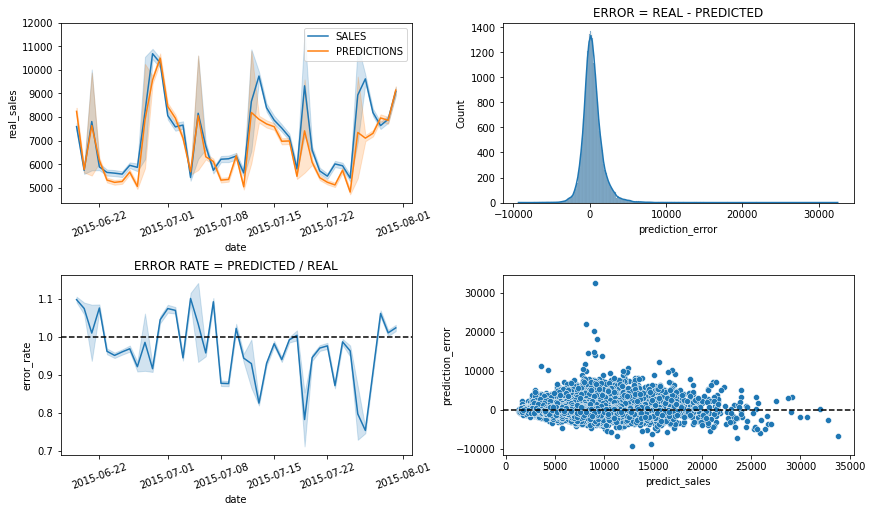

In [146]:
# create a figure object
fig = plt.figure( figsize = (12, 7) , constrained_layout = True )

# create a grid for plotting
# in this case 2 columns and 2 rows
specs = gridspec.GridSpec( ncols = 2, nrows = 2, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 0, 1 ] )
ax4 = fig.add_subplot( specs[ 1, 1 ] )

# plot real sales and predicted sales over time
sns.lineplot( x = 'date', y = 'real_sales', 
              data = df_aux_generalization, label = 'SALES', 
              ax = ax1 )
sns.lineplot( x = 'date', y = 'predict_sales', 
              data = df_aux_generalization, label = 'PREDICTIONS',
              ax = ax1 )
ax1.tick_params( axis = 'x', rotation = 20 )

# plot error rate (predicted / real) over time
sns.lineplot( x = 'date', y = 'error_rate', 
              data = df_aux_generalization, ax = ax2 )
ax2.axhline( 1, linestyle = '--', color = 'black' )
ax2.tick_params( axis = 'x', rotation = 20 )
ax2.set_title( 'ERROR RATE = PREDICTED / REAL' )

# plot error (real - predicted) over time
sns.histplot( x = 'prediction_error', kde = True,
              data = df_aux_generalization, ax = ax3 )
ax3.set_title( 'ERROR = REAL - PREDICTED' )

# plot error against against prediction
sns.scatterplot( x = 'predict_sales', y = 'prediction_error',
              data = df_aux_generalization, ax = ax4 )
ax4.axhline( 1, linestyle = '--', color = 'black' );

# DEPLOYMENT

## Rossmann Class

In [147]:
# import pickle
# import re
# import numpy  as np
# import pandas as pd
# import sklearn

# # NOTE: features that won't be used for prediction will have 
# # their codes commented. The feature transformations for these
# # features will be kept on this code to make code tracking easier
# # for future CRISP cycles. 


# class Rossmann:
#     def __init__( self ): # class constructor

#         # load scalers
#         with open( './parameter/competition_distance_inputter.pkl', 'rb' ) as competition_distance_inputter:
#             self.competition_distance_inputter = pickle.load( competition_distance_inputter )       
#         with open( './parameter/competition_open_since_month_inputter.pkl', 'rb' ) as competition_open_since_month_inputter:
#             self.competition_open_since_month_inputter = pickle.load( competition_open_since_month_inputter )
#         with open( './parameter/competition_open_since_month_scaler.pkl', 'rb' ) as competition_open_since_month_scaler:
#             self.competition_open_since_month_scaler = pickle.load( competition_open_since_month_scaler )
#         with open( './parameter/competition_open_since_year_inputter.pkl', 'rb' ) as competition_open_since_year_inputter:
#             self.competition_open_since_year_inputter = pickle.load( competition_open_since_year_inputter )
#         with open( './parameter/promo2_since_week_inputter.pkl', 'rb' ) as promo2_since_week_inputter:
#             self.promo2_since_week_inputter = pickle.load( promo2_since_week_inputter )
#         with open( './parameter/promo2_since_week_scaler.pkl', 'rb' ) as promo2_since_week_scaler:
#             self.promo2_since_week_scaler = pickle.load( promo2_since_week_scaler )
#         with open( './parameter/promo2_since_year_inputter.pkl', 'rb' ) as promo2_since_year_inputter:
#             self.promo2_since_year_inputter = pickle.load( promo2_since_year_inputter )
#         with open( './parameter/promo2_since_year_scaler.pkl', 'rb' ) as promo2_since_year_scaler:
#             self.promo2_since_year_scaler = pickle.load( promo2_since_year_scaler )
#         # with open( './parameter/promo_interval_inputter.pkl', 'rb' ) as promo_interval_inputter:
#         #     self.promo_interval_inputter = pickle.load( promo_interval_inputter )
#         with open( './parameter/store_scaler.pkl', 'rb' ) as store_scaler:
#             self.store_scaler = pickle.load( store_scaler )
#         # with open( './parameter/year_scaler.pkl', 'rb' ) as year_scaler:
#         #     self.year_scaler = pickle.load( year_scaler )

#     def data_cleaning( self, df_to_clean ):
#         """df_to_clean is the data(frame) to be cleaned"""
  
#         # change from Pascal case to snake case
#         snake_case = [ '_'.join( re.findall('([A-Z][a-z0-9]+)', column) ).lower()
#                         for column in df_to_clean.columns ]
#         df_to_clean.columns = snake_case

#         # convert data column to date format, instead of string
#         df_to_clean['date'] = pd.to_datetime( df_to_clean['date'], format = '%Y-%m-%d' )

#         # transform given column with fitted inputter
#         df_to_clean[ 'competition_distance' ] = self.competition_distance_inputter.transform( df_to_clean[ 'competition_distance' ].values.reshape(-1, 1) )

#         # Data Cleaning is done -> df_dc_done
#         df_dc_done = df_to_clean
        
#         return df_dc_done


#     def feature_engineering( self, df_to_fe ):
#         """df_to_fe is the data(frame) to be engineered"""

#         # convert float columns to integer columns 
#         # as they have interger values
#         # df_to_fe['competition_distance'] = df_to_fe['competition_distance'].astype( int )
#         # df_to_fe['competition_open_since_month'] = df_to_fe['competition_open_since_month'].astype( int )
#         # df_to_fe['competition_open_since_year'] = df_to_fe['competition_open_since_year'].astype( int )
#         # df_to_fe['promo2_since_week'] = df_to_fe['promo2_since_week'].astype( int )
#         # df_to_fe['promo2_since_year'] = df_to_fe['promo2_since_year'].astype( int )


#         # create a column for day of month
#         df_to_fe['day_of_month'] = df_to_fe['date'].dt.day

#         # create day of year
#         df_to_fe['day_of_year'] = df_to_fe['date'].dt.strftime('%j')
#         df_to_fe['day_of_year'] = df_to_fe['day_of_year'].astype( 'int' )

#         # create a column for month
#         df_to_fe['month'] = df_to_fe['date'].dt.month

#         # create a column for year
#         # df_to_fe['year'] = df_to_fe['date'].dt.year

#         # make day_of_week start from 0 -> (sunday = 0)
#         df_to_fe['day_of_week'] = df_to_fe['day_of_week'].apply( lambda x: 0 if x == 7 else x )

#         # create a column for week number 
#         # sunday = 0 to match day_of_week column
#         # df_to_fe['week_number'] = df_to_fe['date'].dt.strftime('%U')
#         # df_to_fe['week_number'] = df_to_fe['week_number'].astype( 'int' );


#         # # get season data
#         # spring = range(3, 5)
#         # summer = range(6, 8)
#         # autumn = range(9, 11)
#         # # winter = everything else

#         # create season column
#         # df_to_fe['season'] = df_to_fe['month'].apply( lambda x: 'spring' if x in spring else
#         #                                                         'summer' if x in summer else
#         #                                                         'autumn' if x in autumn else
#         #                                                         'winter')

#         # Feature Engineering is done -> df_fe_done
#         df_fe_done = df_to_fe


#         return df_fe_done


#     def data_filtering( self, df_to_filter ):
#         """df_to_filter is the data(frame) be (data) filtered"""

#         # remove rows where store is closed
#         df_to_filter = df_to_filter[ df_to_filter['open'] == 1 ]
        
#         # remove open column
#         df_to_filter.drop(columns = ['open'], 
#                           axis = 'columns',
#                           inplace = True)    
        
#         # Data Filtering is done -> df_df_done
#         df_df_done = df_to_filter


#         return df_df_done
        
        
#     def data_preparation( self, df_to_dp ):
#         """df_to_dp is the data(frame) be (data) prepared"""

#         # map assortment column according to database information
#         # Assortment -> a = basic, b = extra, c = extended
#         df_to_dp['assortment'] = df_to_dp['assortment'].apply(lambda x: 'basic' if x == 'a' else
#                                                                     'extra' if x == 'b' else
#                                                                     'extended'
#                                                              )       
                
#         # columns not available in production environment
#         # 'customers' not in production data -> no need to be removed
#         cols_to_remove = ['state_holiday', 'school_holiday', 'promo']
#         # drop columns to be removed
#         df_to_dp.drop( columns = cols_to_remove, axis = 'columns', inplace = True )
   

#         # iterate over columns
#         for column in df_to_dp:

#             ####################
#             dict_inputter = {'competition_open_since_month': self.competition_open_since_month_inputter,
#                             'competition_open_since_year': self.competition_open_since_year_inputter,
#                             'promo2_since_week': self.promo2_since_week_inputter,
#                             'promo2_since_year': self.promo2_since_year_inputter,
#                             # 'promo_interval': self.promo_interval_inputter
#                             }            
            
#             # check if MISSING VALUE INPUTATION is required                      
#             if column in dict_inputter.keys():
#                 # load inputter
#                 inputter = dict_inputter[ column ]
#                 # transform given column with inputter
#                 df_to_dp[ column ] = inputter.transform( df_to_dp[ column ].values.reshape(-1, 1) )


#             ####################    
#             # no NORMALIZATION yet


#             ####################
#             dict_scaler = {'store': self.store_scaler, 
#                            'competition_open_since_month': self.competition_open_since_month_scaler,
#                            'promo2_since_week': self.promo2_since_week_scaler, 
#                            'promo2_since_year': self.promo2_since_year_scaler, 
#                         #    'year': self.year_scaler
#                           }           

#             # check if RESCALING is required
#             if column in dict_scaler.keys():

#                 # load scaler 
#                 scaler = dict_scaler[ column ]
#                 # transform col_outlier
#                 df_to_dp[ column ] = scaler.transform( df_to_dp[ column ].values.reshape(-1,1) )


#             ####################
#             # check if DISCRETIZATION is required
#             if column in ['competition_open_since_year',
#                           'competition_distance'
#                          ]:

#                 # dictionary with feateres and their bins
#                 dict_bins = {'competition_open_since_year': [1989, 1990, 1995, 2000, 2005, 2008, 2010, 2012, 2014, 2016],
#                              'competition_distance': [0, 50, 100, 500, 1000, 5000, 15000, 100000]
#                             }

#                 # discretize column
#                 df_to_dp[ column ] = pd.cut( df_to_dp[ column ], bins = dict_bins[ column ] )
#                 # convert categoric dtype to integer
#                 df_to_dp[ column ] = pd.Categorical( df_to_dp[ column ] ).codes
#                 # make category labels range from 0 to 2
#                 df_to_dp[ column ] = df_to_dp[ column ] / ( ( len( dict_bins[ column ] ) - 2 ) / 2 )



#              ####################       
#             # check if ENCODING is required
#             if column in ['store_type', 
#                           'assortment', 
#                         #   'promo_interval'
#                          ]:

#                 # auxiliary list to encode
#                 aux_dict = {'store_type': {'a': 0, 'd': 1, 'c': 2, 'b': 3},
#                             'assortment': {'basic': 0, 'extended': 1, 'extra': 2},
#                             # 'promo_interval': {'Mar,Jun,Sept,Dec': 0,
#                             #                     'Feb,May,Aug,Nov': 1,
#                             #                     'Jan,Apr,Jul,Oct': 2 }
#                            }

#                 # map feature
#                 df_to_dp[ column ] = df_to_dp[ column ].map( aux_dict[ column ] )


#             ####################
#             # check if NATURE TRANSFORMATION is required
#             if column in [#'season',
#                           'day_of_month',
#                           'day_of_year',
#                           'month',
#                         #   'week_number',
#                           'day_of_week'
#                          ]:

#                 # # check season especific engineering
#                 # if column == 'season':
#                 #     # create season dictionary for mapping
#                 #     season_map = {
#                 #         'winter': 0, 
#                 #         'spring': 1, 
#                 #         'autumn': 2, 
#                 #         'summer': 3
#                 #     }

#                 #     # map season feature
#                 #     df_to_dp['season'] = df_to_dp['season'].map( season_map )

#                 # dict with feature and its cycle
#                 cyclic_dict = {
#                     # 'season': 4,
#                     'day_of_month': 30,
#                     'day_of_year': 365,
#                     'month': 12,
#                     'week_number': 52,
#                     'day_of_week': 7
#                 }

#                 # apply sin and cos transformation on features    
#                 df_to_dp[ f'{column}_sin' ] = df_to_dp[ column ].apply( lambda x: np.sin( x * ( 2. * np.pi/ cyclic_dict[ column ] ) ) )
#                 df_to_dp[ f'{column}_cos' ] = df_to_dp[ column ].apply( lambda x: np.cos( x * ( 2. * np.pi/ cyclic_dict[ column ] ) ) )
#                 # remove cyclic column from dataframe
#                 df_to_dp.drop( columns = [ column ], axis = 'columns', inplace = True )


#         cols_selected = [
#             'store',
#             'store_type',
#             'assortment',
#             'competition_distance',
#             'competition_open_since_month',
#             'competition_open_since_year',
#             'promo2_since_week',
#             'promo2_since_year',
#             'day_of_month_sin',
#             'day_of_month_cos',
#             'day_of_year_sin',
#             'day_of_year_cos',
#             'month_cos',
#             'day_of_week_sin',
#             'day_of_week_cos'
#         ]

#         # select columns
#         df_to_dp = df_to_dp[ cols_selected ]
        
#         # Data Preparation (and feature selection) is is done -> df_dp_done
#         df_dp_done = df_to_dp


#         return df_dp_done


#     def get_prediction( self, ml_model, original_data, prepared_data):
#         """
#         Args:
#             ml_model: model trained
#             original_data: original data sent on request
#             prepared_data: transformed data, ready for prediction
        
#         Return:        
#             pred: sales prediction in the next 6 weeks
#         """

#         # make ML model predict sales on prepared data
#         prediction = ml_model.predict( prepared_data )

#         # convert prediction to normal scale (instead of log scale)
#         # and join prediction as a column onto original dataframe
#         prepared_data['predicted_sales'] = np.expm1( prediction )

#         # note that store number is scaled once data was prepared
#         # to get original store number -> reverse scaling
#         prepared_data[ 'store' ] = self.store_scaler.inverse_transform( prepared_data[ 'store' ].values.reshape(-1,1) )

#         # # calculate sales prediction for each store in the last 6 weeks
#         # stores_prediction = prepared_data[ ['store', 
#         #                                     'predicted_sales'] ].groupby('store').sum().reset_index()

#         # convert the result to json (API transferring format)
#         # df_prediction = stores_prediction.to_json( orient='records', date_format='iso' )
#         df_prediction = prepared_data.to_json( orient='records', date_format='iso' )


#         return df_prediction

## API Handler

In [148]:
# # Library imports
# import pickle
# import os
# import lightgbm
# import pandas              as pd
# from   rossmann.Rossmann   import Rossmann
# from   flask               import Flask, request, Response


# # loading model
# with open('./model/model_rossmann_sales.pkl', 'rb') as file:
#     model = pickle.load( file )


# # Create the app object
# app = Flask( __name__ )

# # create endpoint for request
# @app.route( '/rossmann/predict', methods=['POST'] )
# def rossmann_predict():
#     # get json data on request
#     test_json = request.get_json()   

#     # check if data was sent on request
#     if test_json:
#     # unique row given on the request made: json = dictionary
#         if isinstance( test_json, dict ): 
#             test_raw = pd.DataFrame( test_json, index = [0] )

#         # multiple rows given on the request made
#         else:
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
       
#         # create a copy of original data
#         original_data = test_raw.copy()

#         # Instantiate Rossmann class
#         pipeline = Rossmann()

#         # clean data
#         df_dc_done = pipeline.data_cleaning( test_raw )

#         # engineer data
#         df_fe_done = pipeline.feature_engineering( df_dc_done )

#         # filter data
#         df_df_done = pipeline.data_filtering( df_fe_done )
               
#         # prepare data
#         df_dp_done = pipeline.data_preparation( df_df_done )
       
#         # make prediction
#         df_response = pipeline.get_prediction( model, original_data, df_dp_done )

        
#         return df_response


#     # data was not sent on request
#     else:
#         # mimetype -> from a json application
#         return Response( '{}', status = 200, mimetype = 'application/json' )


# # when handler.py script is run, run flask
# if __name__ == '__main__':
#     port = os.environ.get('PORT', 5000)
#     # '0.0.0.0' is the local host
#     app.run( host = '0.0.0.0', port = port, debug = True )

## API Tester

In [149]:
# load data from test.csv
df_test_extraction = pd.read_csv( '../data/test.csv', low_memory = False )

# load data from store.csv
df_store_supl_extraction = pd.read_csv( '../data/store.csv', low_memory = False )

# merge dataframes on Store column
df_deployment = pd.merge( df_test_extraction, 
                          df_store_supl_extraction,
                          how = 'left', 
                          on = 'Store'
                        )

check_dataframe( df_deployment )

                           Num NAs  Percent NAs  Num unique Data Type
Id                               0        0.000       41088     int64
Store                            0        0.000         856     int64
DayOfWeek                        0        0.000           7     int64
Date                             0        0.000          48    object
Open                            11        0.000           2   float64
Promo                            0        0.000           2     int64
StateHoliday                     0        0.000           2    object
SchoolHoliday                    0        0.000           2     int64
StoreType                        0        0.000           4    object
Assortment                       0        0.000           3    object
CompetitionDistance             96        0.002         554   float64
CompetitionOpenSinceMonth    15216        0.370          12   float64
CompetitionOpenSinceYear     15216        0.370          23   float64
Promo2              

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
24810,24811,1100,4,2015-08-20,1.000,1,0,0,a,a,540.000,NaN,NaN,1,14.000,2011.000,"Jan,Apr,Jul,Oct"
20518,20519,1083,2,2015-08-25,1.000,0,0,1,d,c,11540.000,NaN,NaN,1,5.000,2013.000,"Feb,May,Aug,Nov"
35213,35214,155,5,2015-08-07,1.000,1,0,1,d,a,3050.000,NaN,NaN,1,35.000,2010.000,"Jan,Apr,Jul,Oct"
21888,21889,633,7,2015-08-23,0.000,0,0,0,d,a,11640.000,4.000,2005.000,1,22.000,2011.000,"Jan,Apr,Jul,Oct"
26651,26652,153,1,2015-08-17,1.000,1,0,0,a,a,16240.000,10.000,2000.000,1,18.000,2011.000,"Feb,May,Aug,Nov"


In [150]:
# convert Dataframe to json
data = json.dumps( df_deployment.to_dict( orient = 'records' ) )

In [151]:
import requests

# API url
# local api test
# url = 'http://0.0.0.0:5000/rossmann/predict'
# cloud api test
url = 'https://rossmann-six-weeks-prediction.herokuapp.com/rossmann/predict'
# request header
header = {'Content-type': 'application/json' } 
# data
data = data

# make request
r = requests.post( url, data = data, headers = header )
print( f'Status Code {r.status_code}' )

Status Code 200


In [154]:
# transform api response to pandas dataframe
df_api_test = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

# calculate sales prediction for each store in the last 6 weeks
stores_prediction = df_api_test[ ['store', 
                                  'predicted_sales'] ].groupby('store').sum().reset_index()

stores_prediction

,store,predicted_sales
0,1.000,180117.951
1,3.000,266139.563
2,7.000,357381.321
3,8.000,212857.451
4,9.000,250794.261
...,...,...
851,1111.000,201602.681
852,1112.000,387153.802
853,1113.000,272086.523
854,1114.000,784572.663
